# Data Wrangling

https://www.cbp.gov/newsroom/stats

https://www.uscis.gov/tools/reports-and-studies/immigration-and-citizenship-data


In [49]:
# Imports
import yfinance as yf
import pandas as pd
import json
from io import StringIO
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import time

In [50]:
# Gets a list of all listed companies from SEC's EDGAR database
#"https://www.sec.gov/files/company_tickers.json"

with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
# companies = [entry["ticker"] for entry in response.values()]
# print(companies[:10])  # Print first 10 tickers

In [51]:
### Clean and Aggregate H1B Visa Data by Company Ticker ###

def read_tsv(file_path):
    """Reads a TSV file with UTF-8 encoding."""
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)
    
remove_terms = [
    "INCORPORATED", "INC", "CORPORATION", "CORP", "NA", "N A", "ENTERTAINMENT",
    "CONSULTING", "FINANCIAL", "FINANCIALS", "LOGISTICS", "INDUSTRIES", "MANAGEMENT",
    "LTD", "LIMITED", "LLC", "LLP", "PLC", "GROUP", "GRP", "GR", "HOLDINGS", "COMPANY",
    "CO", "LP", "LL", "PARTNERSHIP", "TECHNOLOGIES", "SYSTEMS", "GLOBAL", "ENTERPRISES",
    "SERVICES", "COM", "COMMUNICATIONS", "SOLUTIONS", "INVESTMENT", "PHARMACEUTICALS", 
    "INTERNATIONAL", "INTL", "WORLDWIDE", "THE", "USA", "US", "U S A" "REFRESHMENTS", "DATA",
    "TELEMATICS", "RESOURCES", "MEDIA", "SVCS", "SUPPORT", "TECH", "OPS", "PLATFORM",
    "PLATFORMS", "CORPORATE", "WEB", "CHEMICAL", "MOTORS", "MOTOR", "ASSOCIATES", "STORES",
    "DEPARTMENT", "DEPT", "AMERICAS", "ENGINEERING", "SOLNS", "TECHNOLOGY", "INFOTECH"
]
remove_terms_pattern = re.compile(r'\b(' + '|'.join(remove_terms) + r')\b')
    
def clean_company_name(name):
    name = str(name).upper()
    name = re.sub(r'\s+', ' ', name).strip()
    name = remove_terms_pattern.sub('', name)
    name = re.sub(r'/[^/]+/', ' ', name)
    name = re.sub(r"[.\,'+()*^#@!]", "", name)
    name = name.replace('-', ' ')
    name = name.replace('&', 'AND')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

company_mapping = {clean_company_name(company['title']): company['ticker'] for company in data.values()}
company_mapping.update({
    "BOEING": "BA", "ATANDT": "T", "FACEBOOK": "META", "GOOGLE": "GOOG", "SNAPCHAT": "SNAP", "KRAFT FOODS": "MDLZ",
    "SQUARE": "SQ", "PRICELINE": "BKNG", "HEWLETT-PACKARD": "HPQ", "TATA CONSULTANCY": "TCS", "MAHINDRA": "TECHM",
    "HCL AMERICA": "HCLTECH.NS", "CAPGEMINI": "CGM", "CAPGEMINI AMERICA": "CGM", "CAPGEMINI U S": "CGM", "IBM": "IBM",
    "CAPITAL ONE": "COF", "CAPITAL ONE II": "COF", "WAL MART": "WMT", "LARSEN AND TOUBRO": "LT", "QUALCOMM": "QCOM", 
    "JPMORGAN CHASE": "JPM", "JPMORGAN CHASE AND": "JPM", "FORD": "F"
})

visa_files = {"h1b": ['data/visas/h1b_2016_2009.csv', 'data/visas/h1b_2019_2017.csv', 'data/visas/h1b_2024_2020.csv']}

df_visas = []
for visa_type, files in visa_files.items():
    df_list = [read_tsv(file) for file in files]
    df = pd.concat(df_list, axis=0)
    df["employer"] = df["Employer (Petitioner) Name"].apply(clean_company_name)
    df["type"] = visa_type
    df_visas.append(df)

df_visas_combined = pd.concat(df_visas)
df_visas_matched = df_visas_combined.copy()

df_visas_matched["ticker"] = df_visas_matched["employer"].map(company_mapping)
df_visas_matched = df_visas_matched[df_visas_matched["ticker"].notna()]

drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Initial Denial', 'Continuing Denial']
df_visas_clean = df_visas_matched.drop(drop_cols, axis=1).copy()
df_visas_clean.columns = df_visas_clean.columns.str.strip()

int_columns = ["Fiscal Year", "Tax ID", "Petitioner Zip Code", "Initial Approval", "Continuing Approval"]
for col in int_columns:
    df_visas_clean[col] = df_visas_clean[col].astype(str).str.replace(",", "", regex=False).str.strip()
    df_visas_clean[col] = pd.to_numeric(df_visas_clean[col], errors="coerce").astype("Int64")

def most_common(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

final_sum = df_visas_clean.groupby(["Fiscal Year", "ticker"], as_index=False).agg({
    "employer": most_common,
    "Tax ID": most_common,
    "Industry (NAICS) Code": most_common,
    "Petitioner City": most_common,
    "Petitioner State": most_common,
    "Petitioner Zip Code": most_common,
    "Initial Approval": "sum",
    "Continuing Approval": "sum",
    "type": "first"
})

h1b_df = final_sum.copy()

In [52]:

def fetch_stock_data(tickers):
    all_data = {}
    print('Downloading yfinance historical price data 2020/01/01 to 2025/03/16')
    num_downloaded = 0
    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2020-01-01", end="2025-03-16", progress = False)
            all_data[ticker] = data
            num_downloaded +=1
            time.sleep(2.2)  # Sleep for 2 seconds between requests to avoid being blocked
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.2)

    print('Successfully downloaded ' + str(num_downloaded/len(tickers)))
    #Save a csv for offline work
    sp500_data = pd.concat(all_data, axis=1)
    sp500_data.to_csv("sp500_data.csv")
    
    print("S&P 500 historical data saved to sp500_data.csv")
    return sp500_data

#Only run this once on your system
#Make sure NOT to track the sp500_data csv
#sp500csv made for offline work
#fetch_stock_data

In [53]:
h1b_df['tot_app'] = h1b_df['Initial Approval'] + h1b_df['Continuing Approval']

In [54]:
h1b_df.head()

Fiscal Year ticker                 employer  Tax ID  \
0         2009      A                  AGILENT    8772   
1         2009     AA                    ALCOA    7820   
2         2009    AAL        AMERICAN AIRLINES    5172   
3         2009   AAMI            ACADIAN ASSET    9221   
4         2009   AAOI  APPLIED OPTOELECTRONICS    3927   

                    Industry (NAICS) Code Petitioner City Petitioner State  \
0                   31-33 - Manufacturing     SANTA CLARA               CA   
1                   31-33 - Manufacturing    ALCOA CENTER               PA   
2  48-49 - Transportation and Warehousing      FORT WORTH               TX   
3              52 - Finance and Insurance          BOSTON               MA   
4                   31-33 - Manufacturing      SUGAR LAND               TX   

   Petitioner Zip Code  Initial Approval  Continuing Approval type  tot_app  
0                95051                13                   21  h1b       34  
1                15069                 3                    4  h1b        7  
2                76155                31                   34  h1b       65  
3                 2109                 0                    2  h1b        2  
4                77478                 4                    1  h1b        5

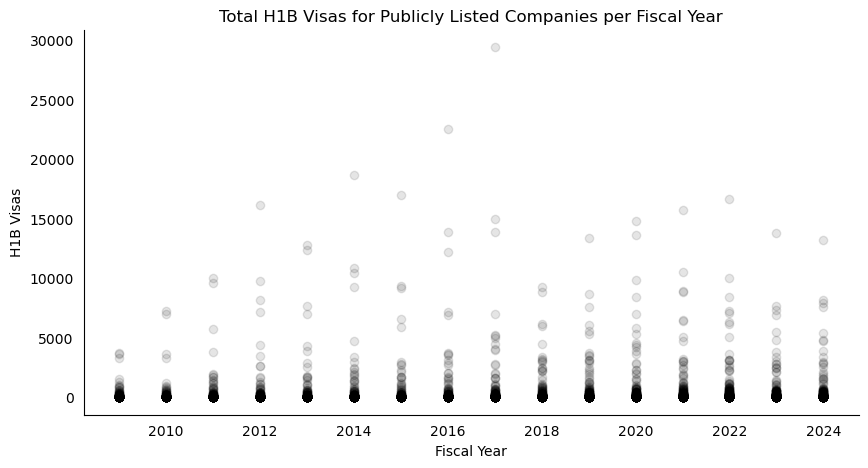

In [55]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax.scatter('Fiscal Year', 'tot_app' ,data = h1b_df, color='black', alpha = .1)  

ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

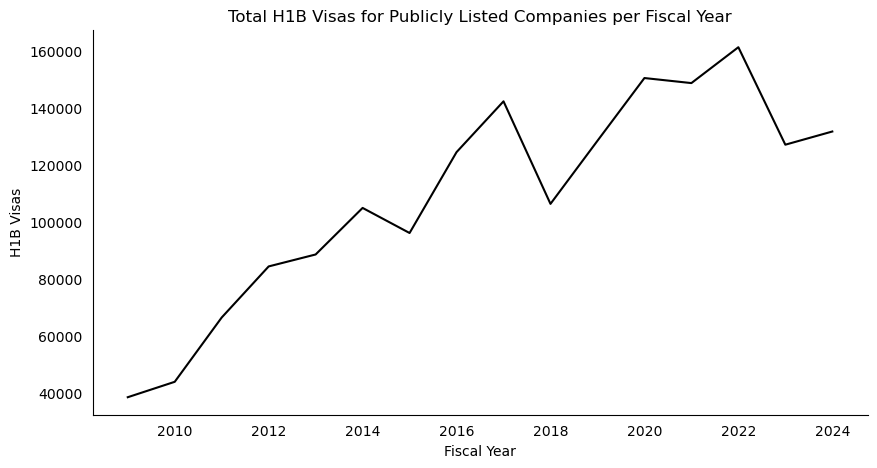

In [56]:
year_sums = h1b_df.groupby('Fiscal Year').sum().loc[:, ['tot_app']].reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'tot_app' ,data = year_sums, color='black')  
ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()


In [57]:
#Run once to have data locally
voo_data = yf.download('VOO', start="2008-01-01", end="2025-01-01", progress = False, interval='1wk')
#voo_data.to_csv('data/voo_hist_data.csv')
#voo_data = pd.read_csv('data/voo_hist_data.csv')
voo_data.head()

Price           Close       High        Low       Open  Volume
Ticker            VOO        VOO        VOO        VOO     VOO
Date                                                          
2010-09-06  77.804474  78.354870  77.315234  78.354870   35100
2010-09-13  79.012245  79.409750  78.263094  78.706469  211300
2010-09-20  80.143631  80.602298  78.828803  79.302751  113800
2010-09-27  80.486671  81.224516  79.487503  80.686506  142600
2010-10-04  81.993095  82.039209  79.548982  80.901700  496900

In [58]:
voo_data['year'] = voo_data.index.year
yearly_voo = voo_data.groupby('year').mean().droplevel('Ticker', axis=1)
yearly_voo.head()

Price       Close        High         Low        Open        Volume
year                                                               
2010    83.894032   84.346598   82.488781   83.438494  2.457647e+05
2011    90.351374   91.944938   88.499463   90.294928  1.089531e+06
2012   100.639402  101.689033   99.149782  100.294879  1.978665e+06
2013   123.059821  123.885115  121.346609  122.589878  4.896577e+06
2014   147.051355  148.269508  145.189706  146.769968  6.308038e+06

In [59]:
yearly_voo['vol_change'] = yearly_voo['Volume'].pct_change()
yearly_voo['open_change'] = yearly_voo['Open'].pct_change()
yearly_voo['close_change'] = yearly_voo['Close'].pct_change()
yearly_voo.head()

Price       Close        High         Low        Open        Volume  \
year                                                                  
2010    83.894032   84.346598   82.488781   83.438494  2.457647e+05   
2011    90.351374   91.944938   88.499463   90.294928  1.089531e+06   
2012   100.639402  101.689033   99.149782  100.294879  1.978665e+06   
2013   123.059821  123.885115  121.346609  122.589878  4.896577e+06   
2014   147.051355  148.269508  145.189706  146.769968  6.308038e+06   

Price  vol_change  open_change  close_change  
year                                          
2010          NaN          NaN           NaN  
2011     3.433227     0.082174      0.076970  
2012     0.816071     0.110748      0.113867  
2013     1.474687     0.222294      0.222780  
2014     0.288255     0.197244      0.194958

In [60]:
year_sums['chng'] = year_sums['tot_app'].pct_change()

In [61]:
combined = yearly_voo.merge(year_sums, left_on='year', right_on='Fiscal Year')

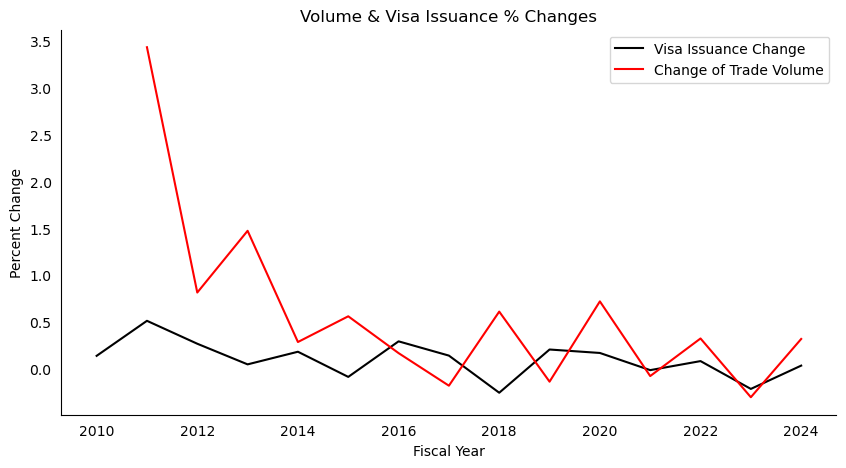

In [62]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change", data = combined, color='black')  
ax.plot('Fiscal Year', 'vol_change' , label = "Change of Trade Volume", data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Volume & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

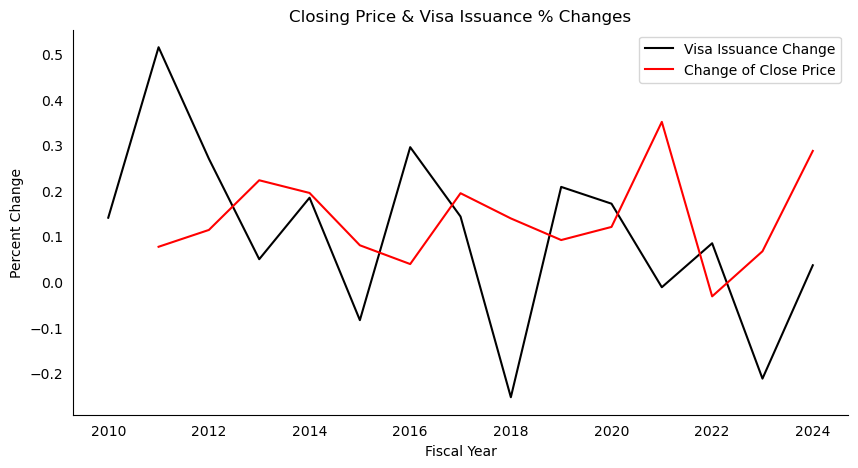

In [63]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change",data = combined, color='black')  
ax.plot('Fiscal Year', 'close_change' ,label = "Change of Close Price",data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

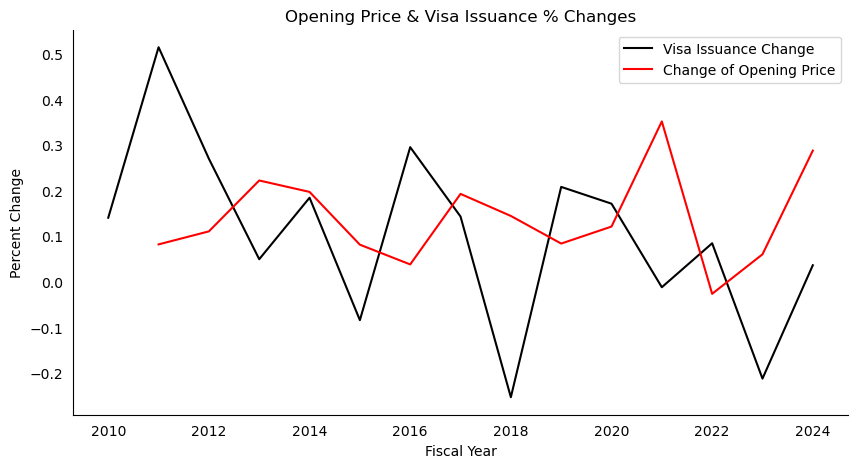

In [64]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change",data = combined, color='black')  
ax.plot('Fiscal Year', 'open_change' ,label = "Change of Opening Price",data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Opening Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

In [65]:
def fetch_stock_info(tickers):
    #all_data = {}
    infor = {}
    dict_list = []
    print('Downloading yfinance information on select tickers...')
    for ticker in tickers:
        try:
            infor[ticker] = yf.Ticker(ticker).info
            time.sleep(2.001)  # Sleep for 2 seconds between requests to avoid being blocked

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.001)
    return pd.DataFrame(infor)

In [66]:
#company_info_df = fetch_stock_info(h1b_df['ticker'].unique())
#company_info_df.to_csv('company_info_df.csv')

In [67]:
company_info_df = pd.read_csv('company_info_df.csv').T
company_info_df = company_info_df.rename(columns=company_info_df.iloc[0]).drop(company_info_df.index[0])
company_info_df.head()

address1         city state         zip  \
A     5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
AA             201 Isabella Street   Pittsburgh    PA  15212-5858   
AAL                1 Skyview Drive   Fort Worth    TX       76155   
AAMI          200 Clarendon Street       Boston    MA       02116   
AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

            country           phone           fax                  website  \
A     United States    800 227 9770  866 497 1134  https://www.agilent.com   
AA    United States    412 315 2900           NaN    https://www.alcoa.com   
AAL   United States    682 278 9000           NaN       https://www.aa.com   
AAMI  United States    617-369-7300           NaN     https://www.bsig.com   
AAOI  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                     industry              industryKey  ... fundFamily  \
A      Diagnostics & Research     diagnostics-research  ...        NaN   
AA                   Aluminum                 aluminum  ...        NaN   
AAL                  Airlines                 airlines  ...        NaN   
AAMI         Asset Management         asset-management  ...        NaN   
AAOI  Communication Equipment  communication-equipment  ...        NaN   

     fundInceptionDate legalType threeYearAverageReturn  \
A                  NaN       NaN                    NaN   
AA                 NaN       NaN                    NaN   
AAL                NaN       NaN                    NaN   
AAMI               NaN       NaN                    NaN   
AAOI               NaN       NaN                    NaN   

     trailingThreeMonthReturns trailingThreeMonthNavReturns netAssets  \
A                          NaN                          NaN       NaN   
AA                         NaN                          NaN       NaN   
AAL                        NaN                          NaN       NaN   
AAMI                       NaN                          NaN       NaN   
AAOI                       NaN                          NaN       NaN   

     netExpenseRatio fiveYearAverageReturn newSymbol  
A                NaN                   NaN       NaN  
AA               NaN                   NaN       NaN  
AAL              NaN                   NaN       NaN  
AAMI             NaN                   NaN       NaN  
AAOI             NaN                   NaN       NaN  

[5 rows x 198 columns]

In [68]:
drop_cols_2 = []
for x in company_info_df.columns:
    if x in ["sector", "auditRisk", "boardRisk", "overallRisk", "totalAssets"]:
        continue
    if len(company_info_df[x].unique()) < 20:
        drop_cols_2.append(x)

In [69]:
company_info_df = company_info_df.drop(drop_cols_2, axis = 1)
company_info_df.head()

address1         city state         zip  \
A     5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
AA             201 Isabella Street   Pittsburgh    PA  15212-5858   
AAL                1 Skyview Drive   Fort Worth    TX       76155   
AAMI          200 Clarendon Street       Boston    MA       02116   
AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

            country           phone           fax                  website  \
A     United States    800 227 9770  866 497 1134  https://www.agilent.com   
AA    United States    412 315 2900           NaN    https://www.alcoa.com   
AAL   United States    682 278 9000           NaN       https://www.aa.com   
AAMI  United States    617-369-7300           NaN     https://www.bsig.com   
AAOI  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                     industry              industryKey  ...  \
A      Diagnostics & Research     diagnostics-research  ...   
AA                   Aluminum                 aluminum  ...   
AAL                  Airlines                 airlines  ...   
AAMI         Asset Management         asset-management  ...   
AAOI  Communication Equipment  communication-equipment  ...   

     averageAnalystRating firstTradeDateMilliseconds regularMarketChange  \
A               2.1 - Buy               942935400000          0.98000336   
AA              1.7 - Buy              -252322200000           1.1750011   
AAL             2.1 - Buy              1127827800000          0.16989994   
AAMI           3.0 - Hold              1412861400000          0.34000015   
AAOI            1.8 - Buy              1380202200000          0.70440006   

     regularMarketDayRange               displayName trailingPegRatio  \
A           103.16 - 106.0                   Agilent           1.7168   
AA           25.28 - 26.24                     Alcoa              NaN   
AAL            9.21 - 9.68         American Airlines           0.2903   
AAMI       26.2151 - 26.89  Acadian Asset Management              NaN   
AAOI        11.535 - 12.59   Applied Optoelectronics              NaN   

        address2                            prevName ipoExpectedDate  \
A            NaN                                 NaN             NaN   
AA     Suite 500                                 NaN             NaN   
AAL          NaN                                 NaN             NaN   
AAMI  53rd Floor  BrightSphere Investment Group Inc.             NaN   
AAOI         NaN                                 NaN             NaN   

     totalAssets  
A            NaN  
AA           NaN  
AAL          NaN  
AAMI         NaN  
AAOI         NaN  

[5 rows x 148 columns]

In [70]:
company_info_df.to_csv("company_info_df_clean.csv")


In [71]:
company_info_df = pd.read_csv("company_info_df_clean.csv")

In [72]:
h1b_2024 = h1b_df[h1b_df['Fiscal Year'] == 2024]
h1b_2024.head()

Fiscal Year ticker                 employer  Tax ID  \
18990         2024      A                  AGILENT    8772   
18991         2024     AA                    ALCOA    9115   
18992         2024    AAL        AMERICAN AIRLINES    2798   
18993         2024   AAMI            ACADIAN ASSET    9221   
18994         2024   AAOI  APPLIED OPTOELECTRONICS    3927   

                        Industry (NAICS) Code Petitioner City  \
18990                   31-33 - Manufacturing     SANTA CLARA   
18991                   31-33 - Manufacturing      PITTSBURGH   
18992  48-49 - Transportation and Warehousing      FORT WORTH   
18993              52 - Finance and Insurance          BOSTON   
18994                   31-33 - Manufacturing      SUGAR LAND   

      Petitioner State  Petitioner Zip Code  Initial Approval  \
18990               CA                95052                11   
18991               PA                15212                 1   
18992               TX                76155                43   
18993               MA                 2110                 4   
18994               TX                77478                 4   

       Continuing Approval type  tot_app  
18990                   24  h1b       35  
18991                    2  h1b        3  
18992                  228  h1b      271  
18993                    4  h1b        8  
18994                    6  h1b       10

In [73]:
visa_and_info_df = company_info_df.merge(h1b_2024, how = 'inner', left_on='symbol', right_on='ticker')
visa_and_info_df = visa_and_info_df[visa_and_info_df['country']=='United States']
visa_and_info_df.head()

Unnamed: 0                      address1         city state         zip  \
0          A  5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
1         AA           201 Isabella Street   Pittsburgh    PA  15212-5858   
2        AAL               1 Skyview Drive   Fort Worth    TX       76155   
3       AAMI          200 Clarendon Street       Boston    MA       02116   
4       AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

         country           phone           fax                  website  \
0  United States    800 227 9770  866 497 1134  https://www.agilent.com   
1  United States    412 315 2900           NaN    https://www.alcoa.com   
2  United States    682 278 9000           NaN       https://www.aa.com   
3  United States    617-369-7300           NaN     https://www.bsig.com   
4  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                  industry  ...                 employer Tax ID  \
0   Diagnostics & Research  ...                  AGILENT   8772   
1                 Aluminum  ...                    ALCOA   9115   
2                 Airlines  ...        AMERICAN AIRLINES   2798   
3         Asset Management  ...            ACADIAN ASSET   9221   
4  Communication Equipment  ...  APPLIED OPTOELECTRONICS   3927   

                    Industry (NAICS) Code Petitioner City  Petitioner State  \
0                   31-33 - Manufacturing     SANTA CLARA                CA   
1                   31-33 - Manufacturing      PITTSBURGH                PA   
2  48-49 - Transportation and Warehousing      FORT WORTH                TX   
3              52 - Finance and Insurance          BOSTON                MA   
4                   31-33 - Manufacturing      SUGAR LAND                TX   

  Petitioner Zip Code  Initial Approval  Continuing Approval  type tot_app  
0               95052                11                   24   h1b      35  
1               15212                 1                    2   h1b       3  
2               76155                43                  228   h1b     271  
3                2110                 4                    4   h1b       8  
4               77478                 4                    6   h1b      10  

[5 rows x 161 columns]

Text(0.5, 1.0, 'Number of H1B Visas per Industry')

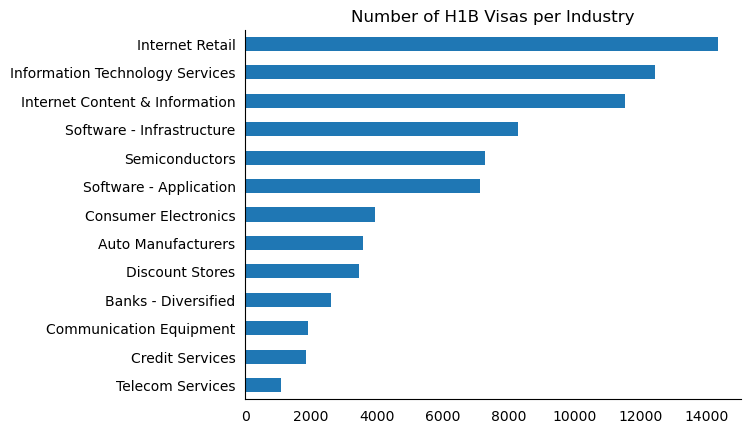

In [74]:
visa_and_info_df.groupby('industry').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.ylabel("")
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.title("Number of H1B Visas per Industry")
#plt.bar(visa_and_info_df.groupby('industry').sum()['tot_app'])

Text(0.5, 1.0, 'Number of H1B Visas per Sector')

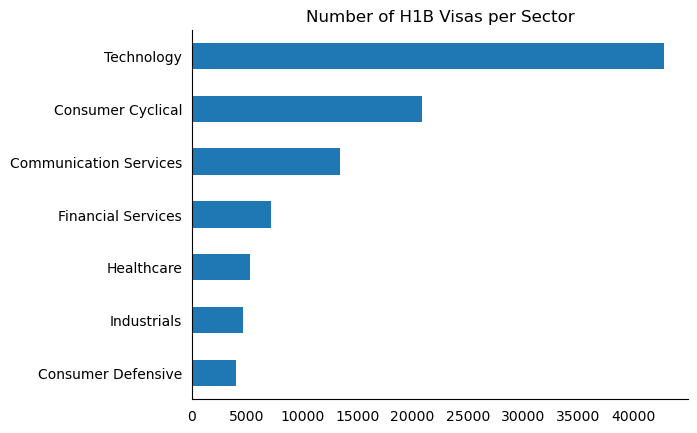

In [75]:
visa_and_info_df.groupby('sector').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.ylabel("")
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.title("Number of H1B Visas per Sector")

Text(0.5, 1.0, 'Number of H1B Visas per City')

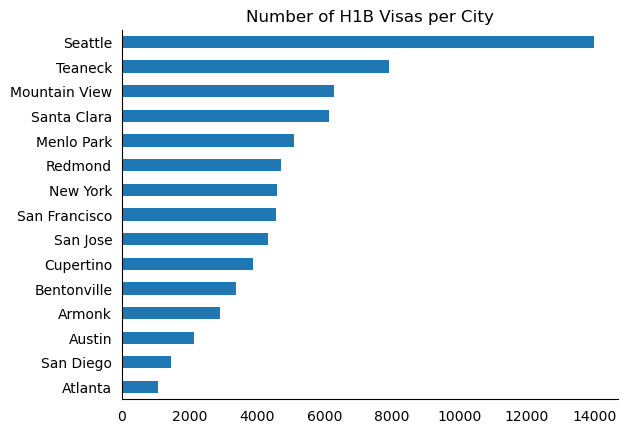

In [76]:
visa_and_info_df.groupby('city').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.ylabel("")
plt.title("Number of H1B Visas per City")

Text(0.5, 1.0, 'Number of H1B Visas per State')

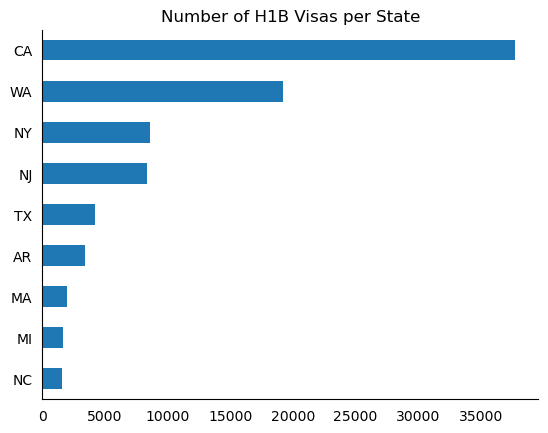

In [77]:
visa_and_info_df.groupby('state').sum()['tot_app'].loc[lambda x: x > 1500].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.ylabel("")
plt.title("Number of H1B Visas per State")

In [78]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

fullTimeEmployees


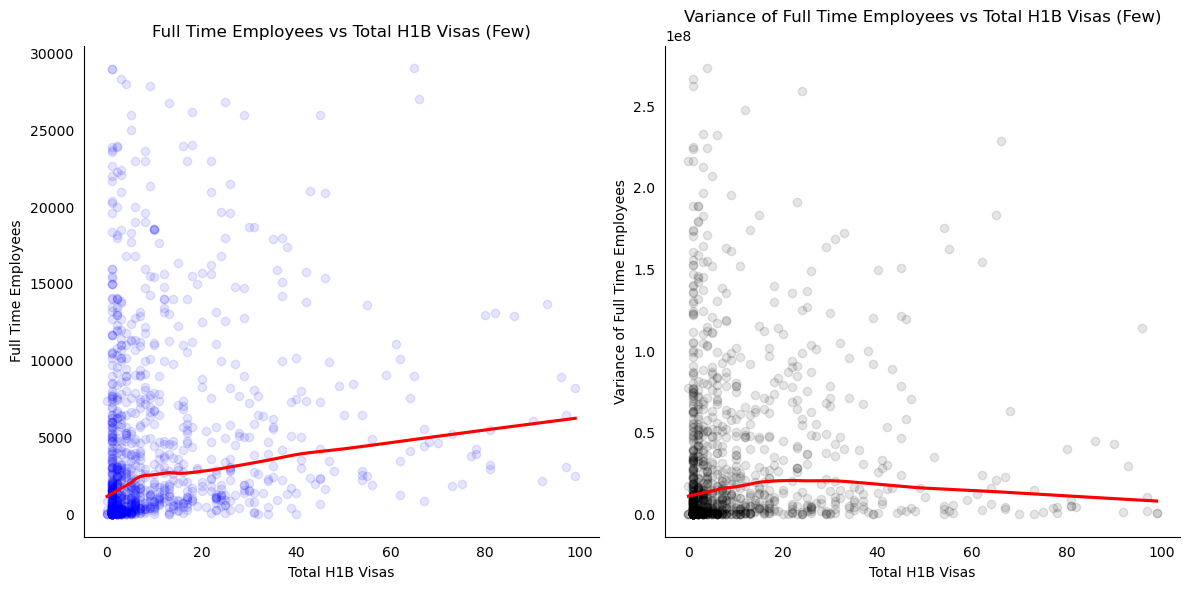

auditRisk


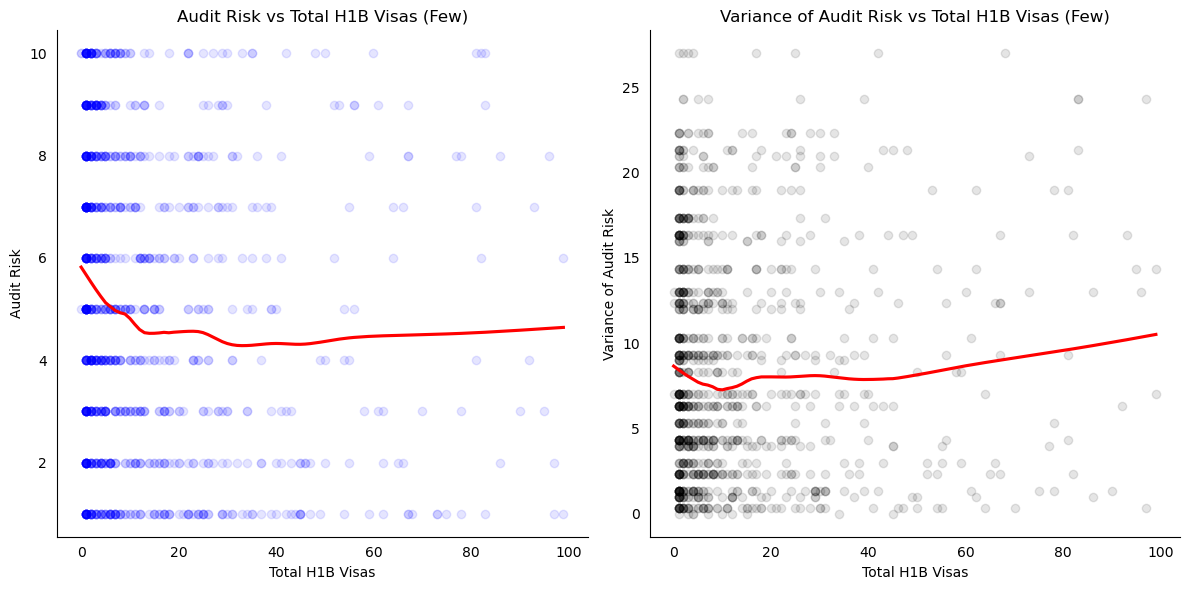

beta


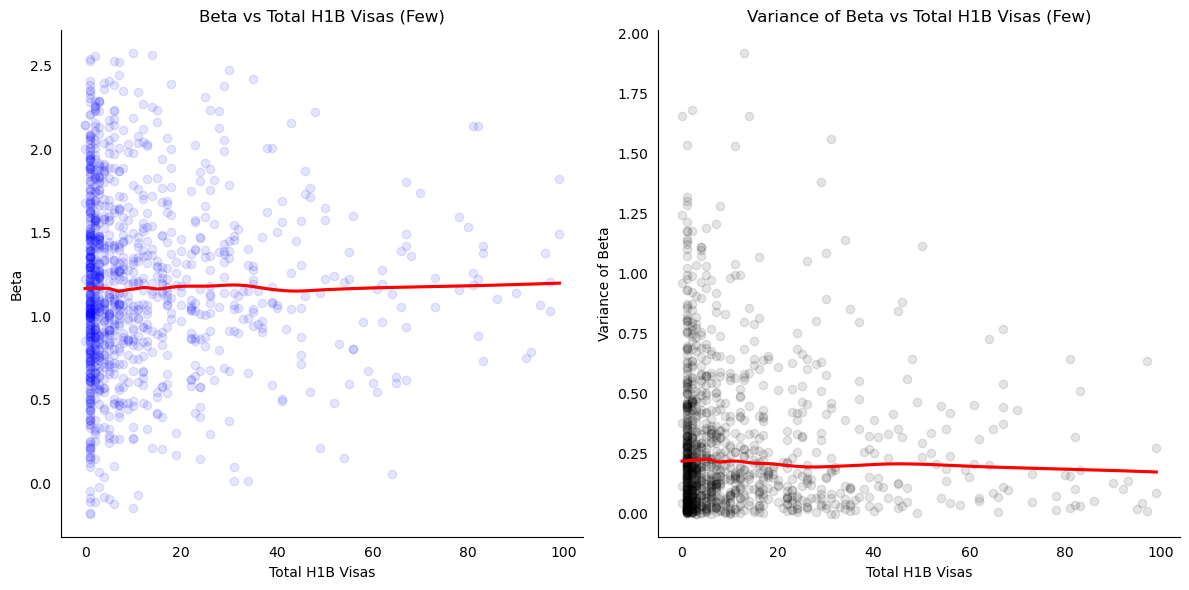

forwardPE


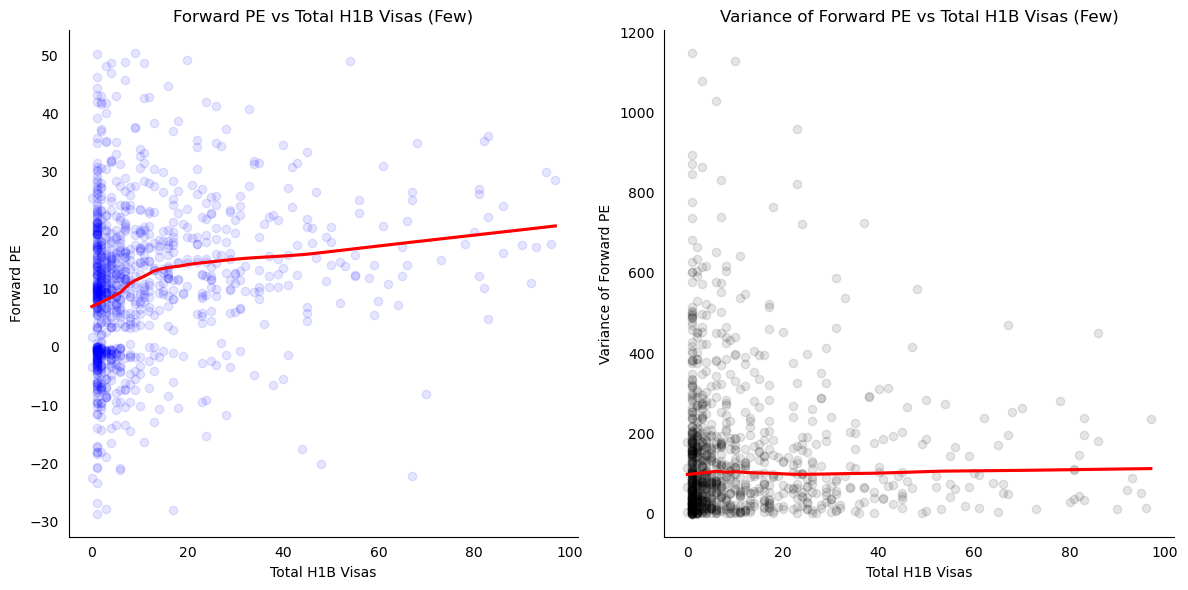

profitMargins


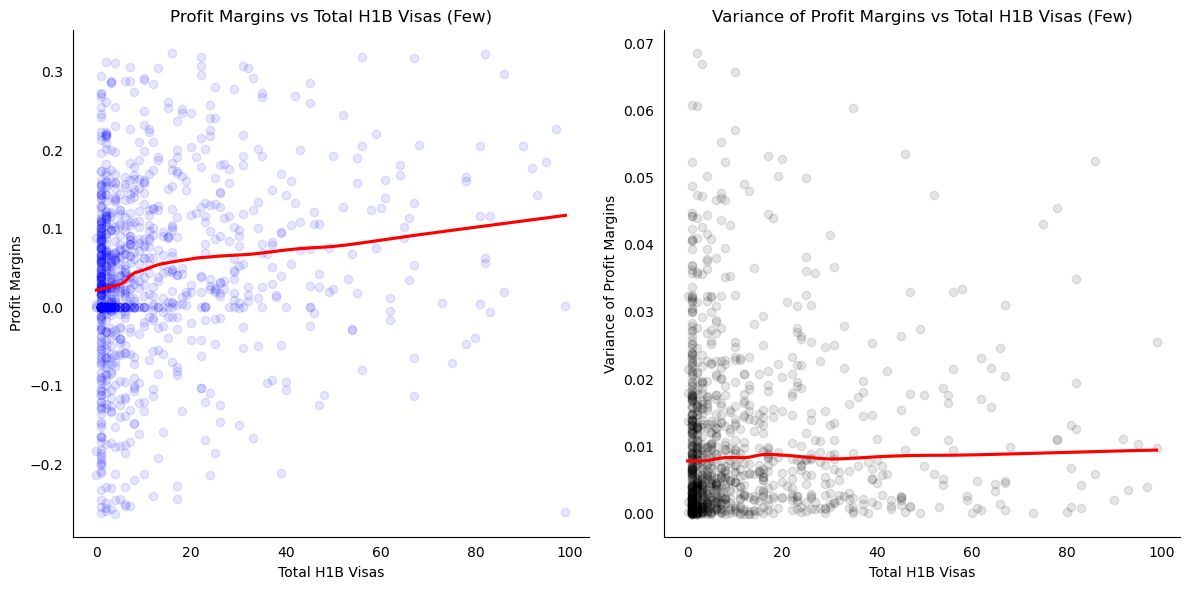

sharesPercentSharesOut


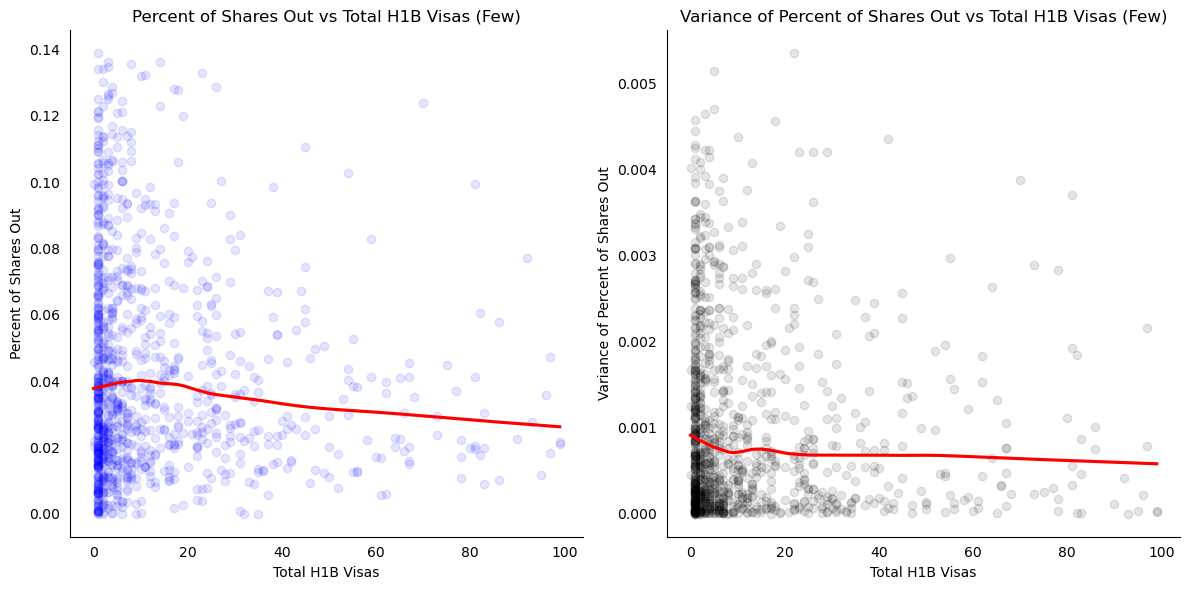

heldPercentInstitutions


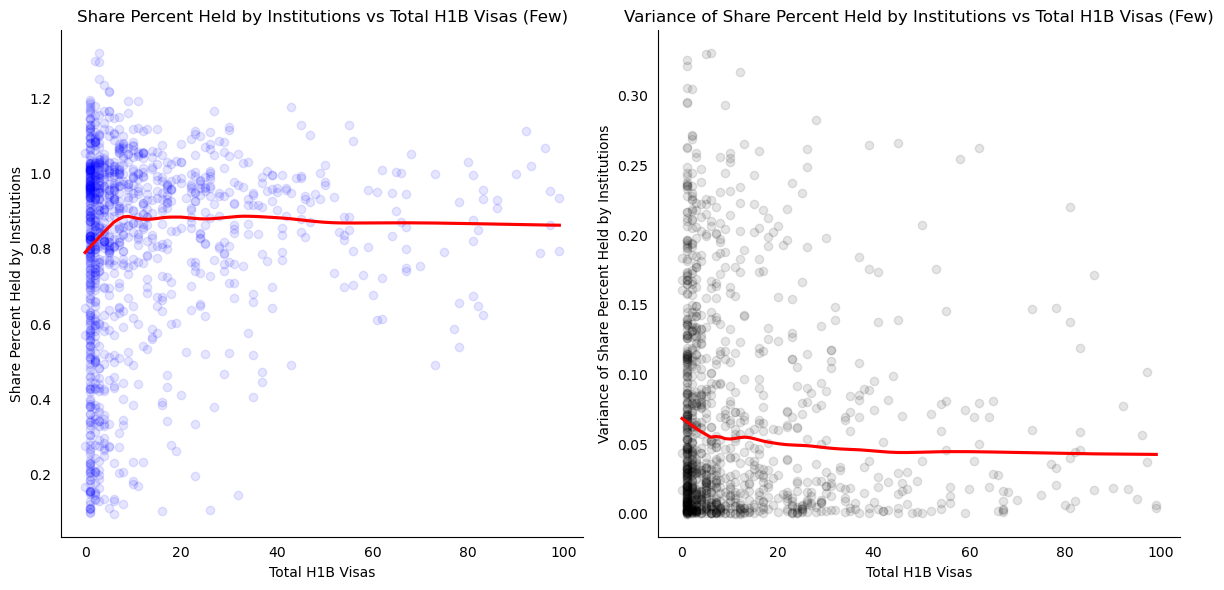

shortRatio


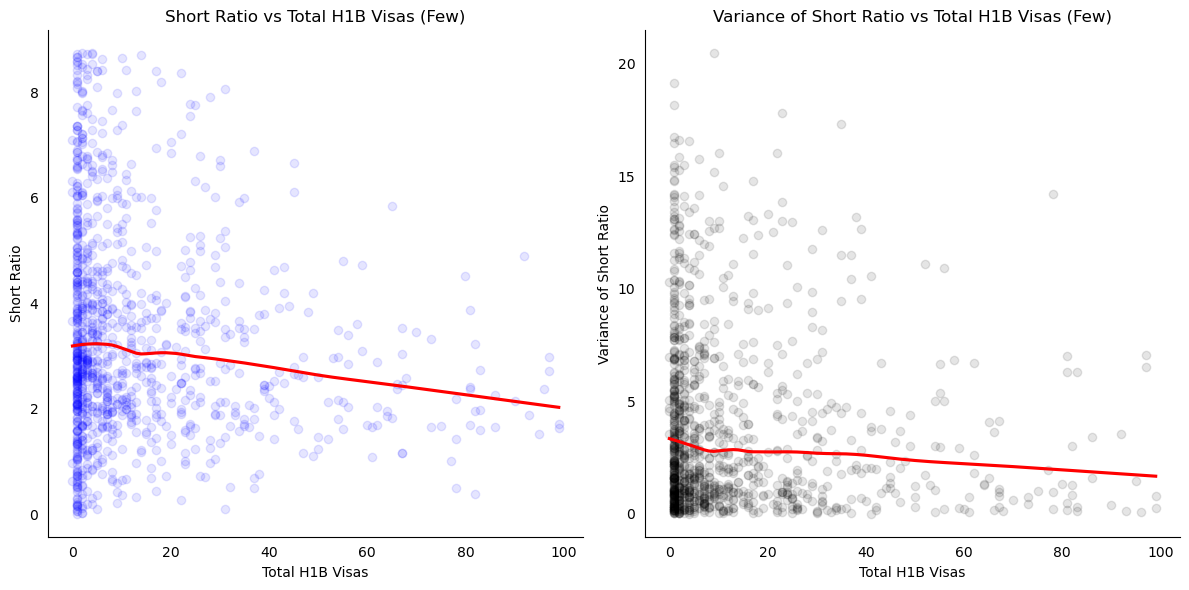

priceToBook


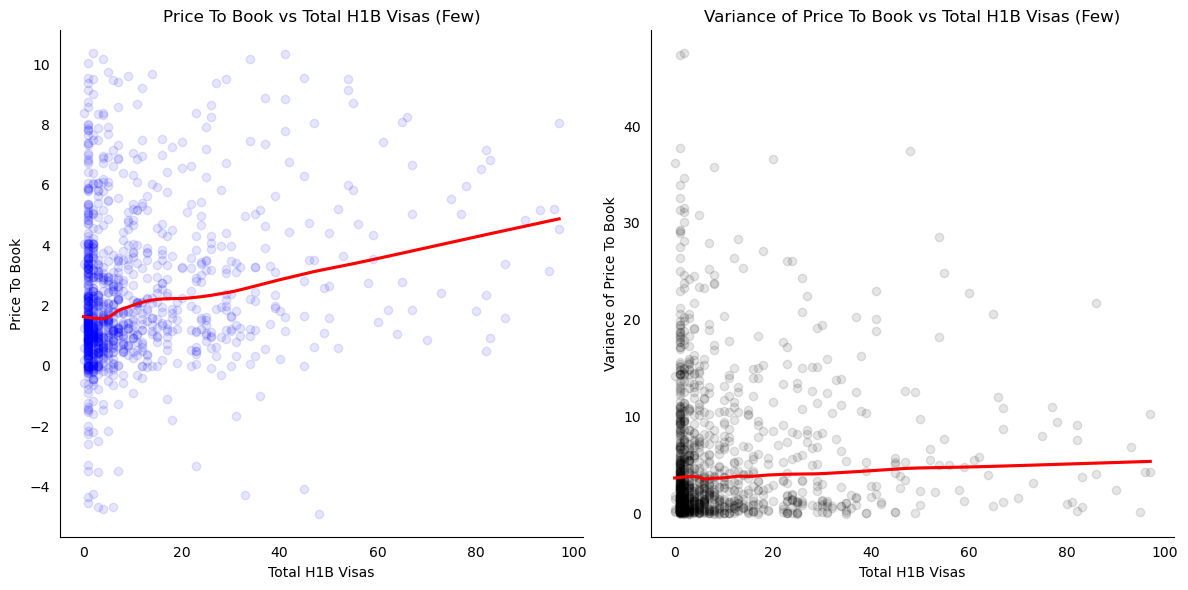

earningsQuarterlyGrowth


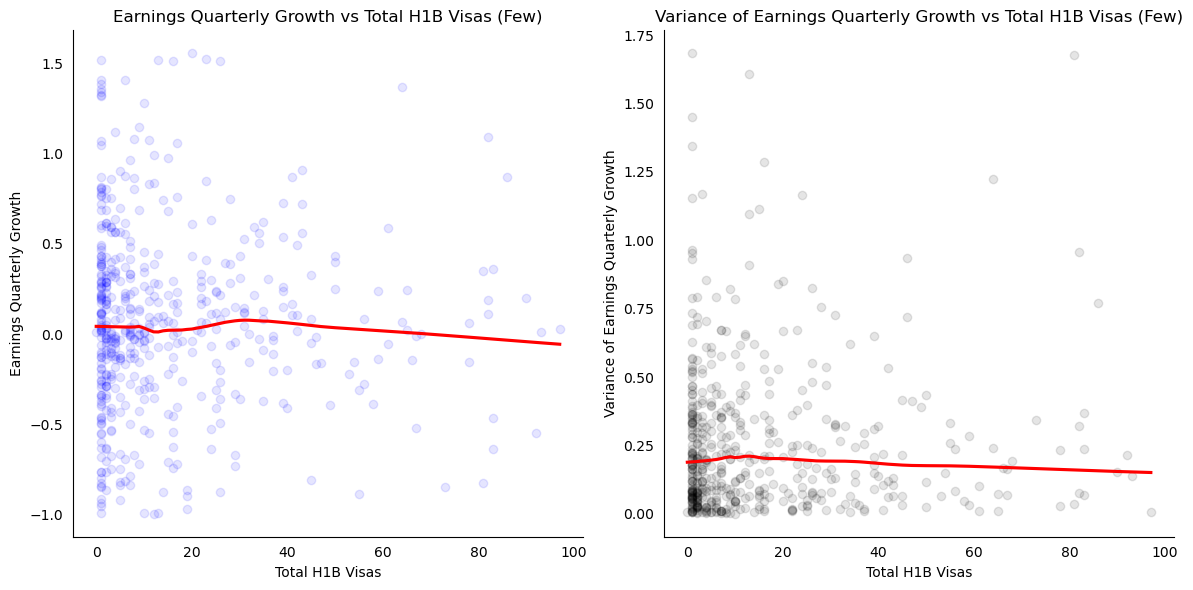

52WeekChange


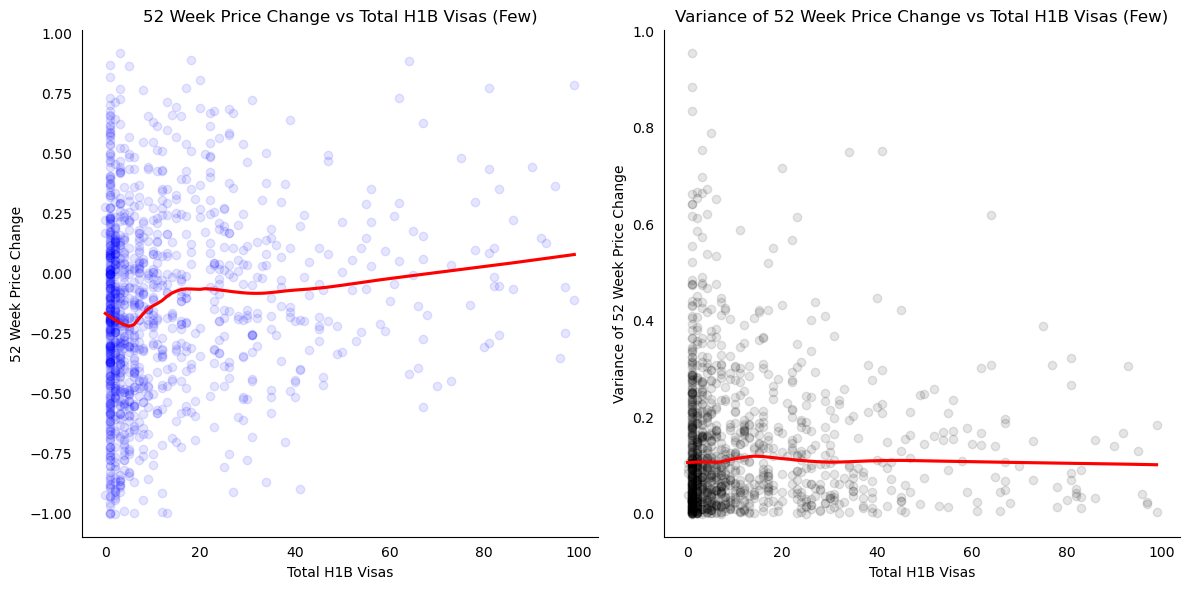

returnOnAssets


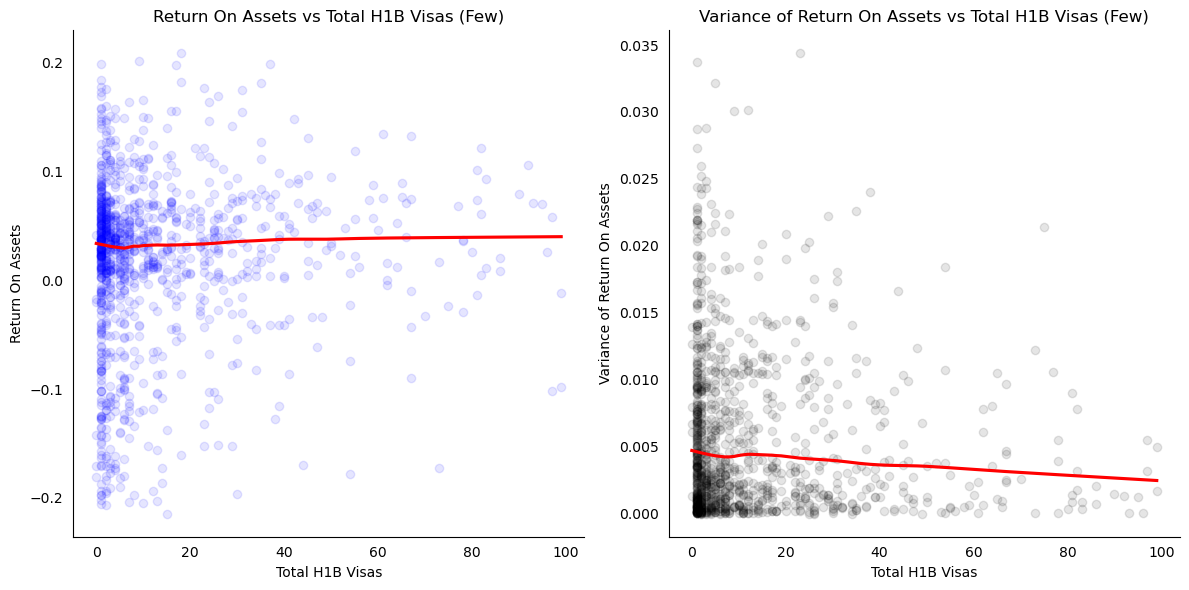

returnOnEquity


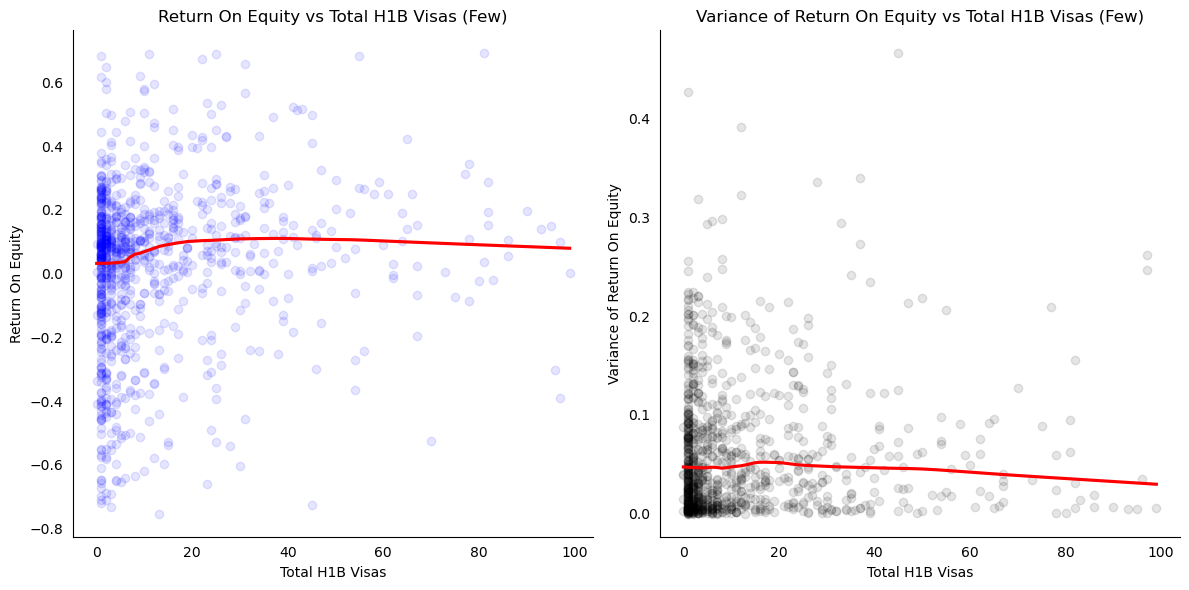

revenueGrowth


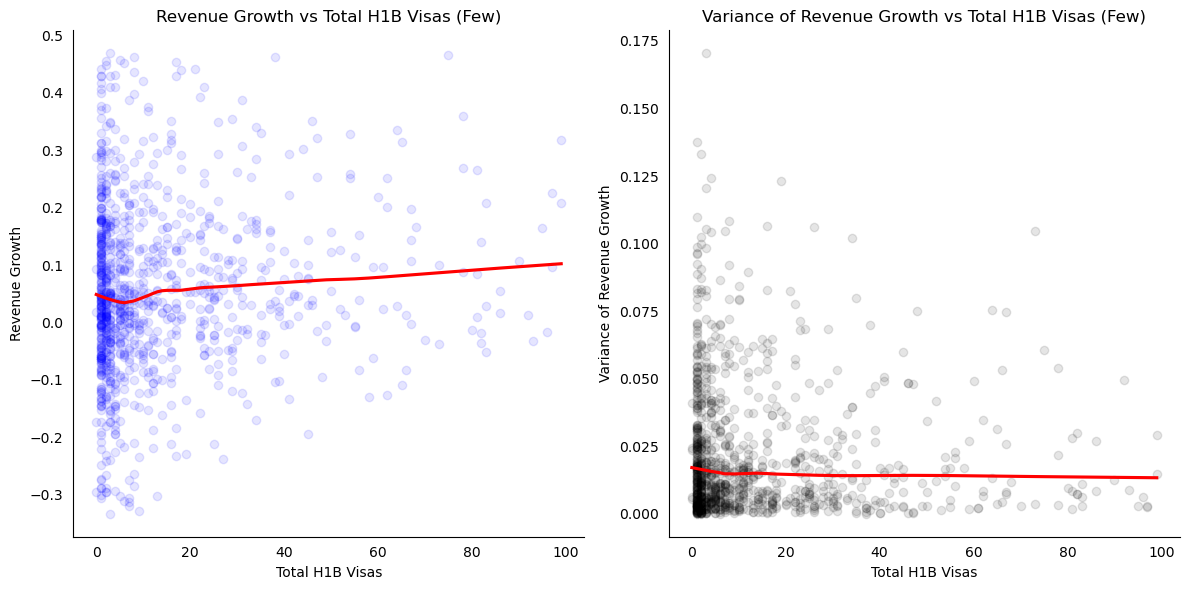

fiftyTwoWeekChangePercent


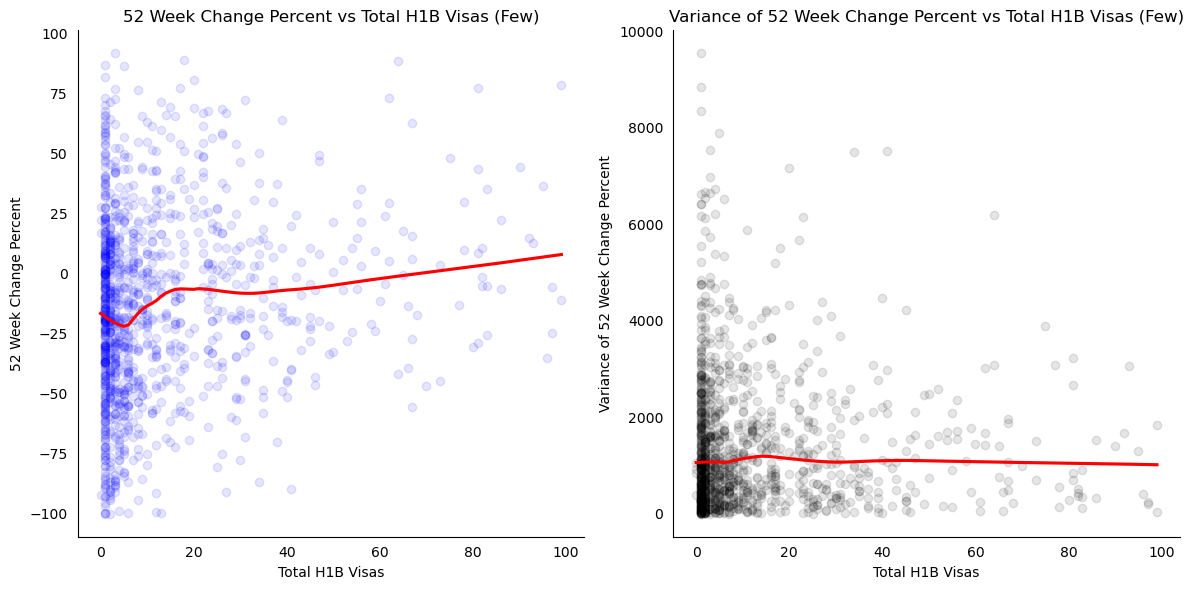

fiftyDayAverageChangePercent


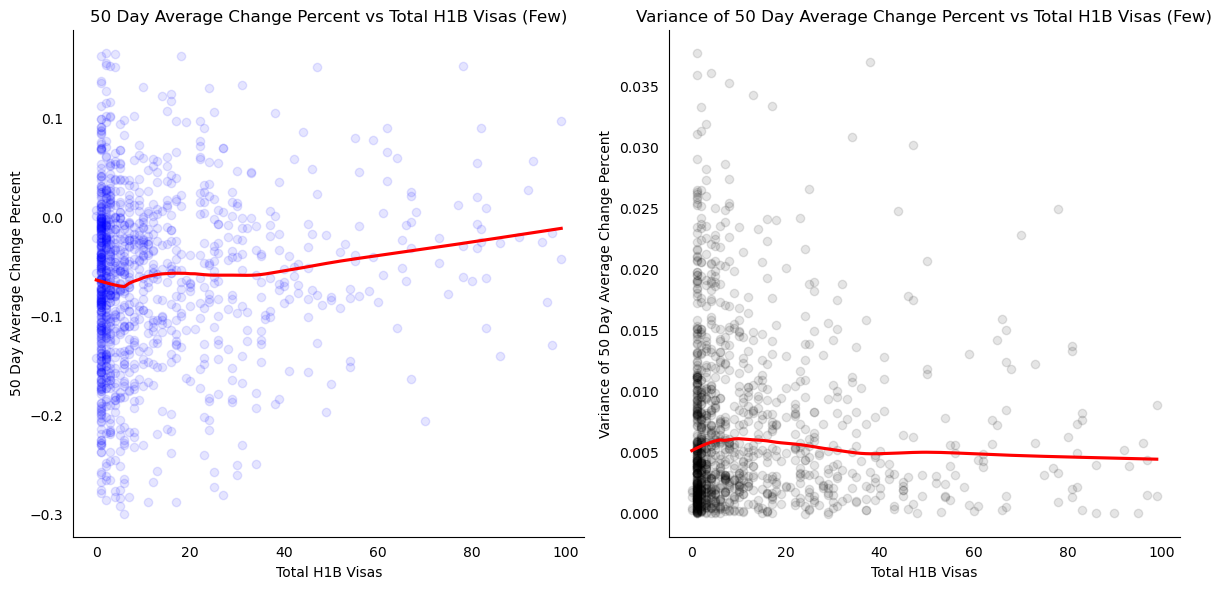

twoHundredDayAverageChangePercent


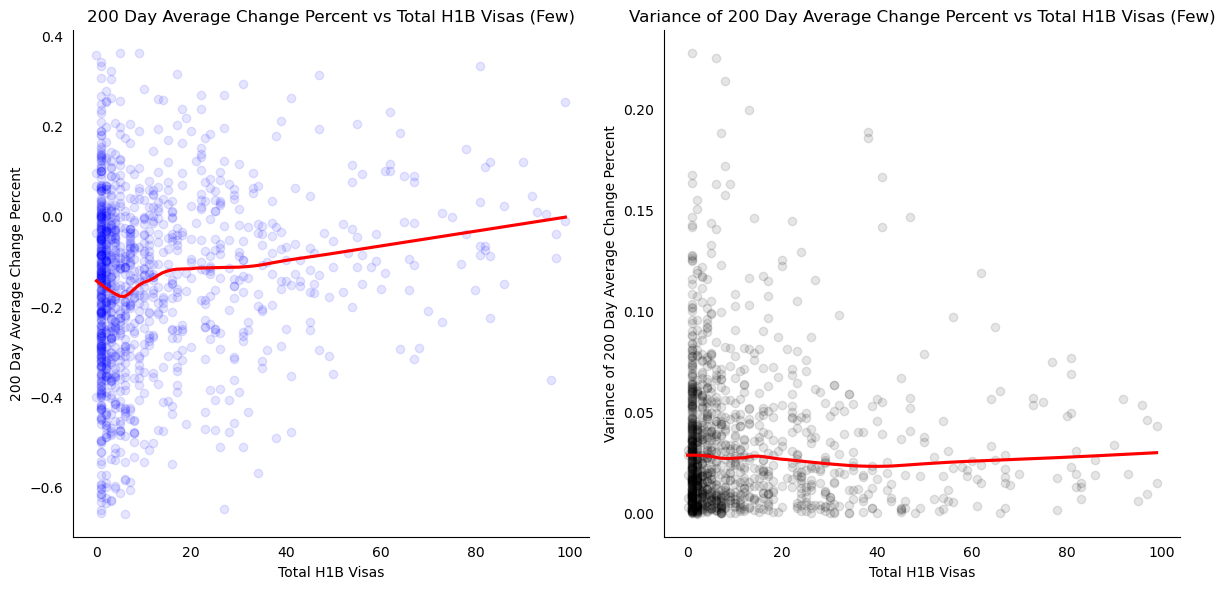

In [112]:
target_col = 'tot_app'
graphs_with_patterns = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent']
pretty_titles = ['Full Time Employees', 'Audit Risk', 'Beta', 'Forward PE', 'Profit Margins', 'Percent of Shares Out', 
                        'Share Percent Held by Institutions', 'Short Ratio', 'Price To Book', 'Earnings Quarterly Growth', '52 Week Price Change', 
                        'Return On Assets', 'Return On Equity', 'Revenue Growth', '52 Week Change Percent', '50 Day Average Change Percent', '200 Day Average Change Percent']

for n in range(17):
        col = graphs_with_patterns[n]
        if  col!= target_col:
            print(col)
            data = remove_outliers_iqr(visa_and_info_df, col)
            few_visas = data[data['tot_app'] <= 100]
            many_visas = data[data['tot_app'] > 100]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            sns.regplot(x=few_visas[target_col], y=few_visas[col], ax=axs[0], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
            axs[0].set_title(f'{pretty_titles[n]} vs Total H1B Visas (Few)')
            axs[0].set_xlabel('Total H1B Visas')
            axs[0].set_ylabel(pretty_titles[n])
            axs[0].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[0].tick_params(axis='y', which='both', left=False)

            sns.regplot(x=few_visas[target_col], y=few_visas[col].rolling(window=3).var(), ax=axs[1], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'black'}, line_kws={'color': 'red'})
            axs[1].set_title(f'Variance of {pretty_titles[n]} vs Total H1B Visas (Few)')
            axs[1].set_ylabel(f'Variance of {pretty_titles[n]}')
            axs[1].set_xlabel('Total H1B Visas')
            axs[1].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[1].tick_params(axis='y', which='both', left=False)

            plt.tick_params(axis='x', which='both', bottom=False, top=False) 
            plt.tick_params(axis='y', which='both', left=False)
            sns.despine()
            plt.tight_layout()
            plt.show()

fullTimeEmployees


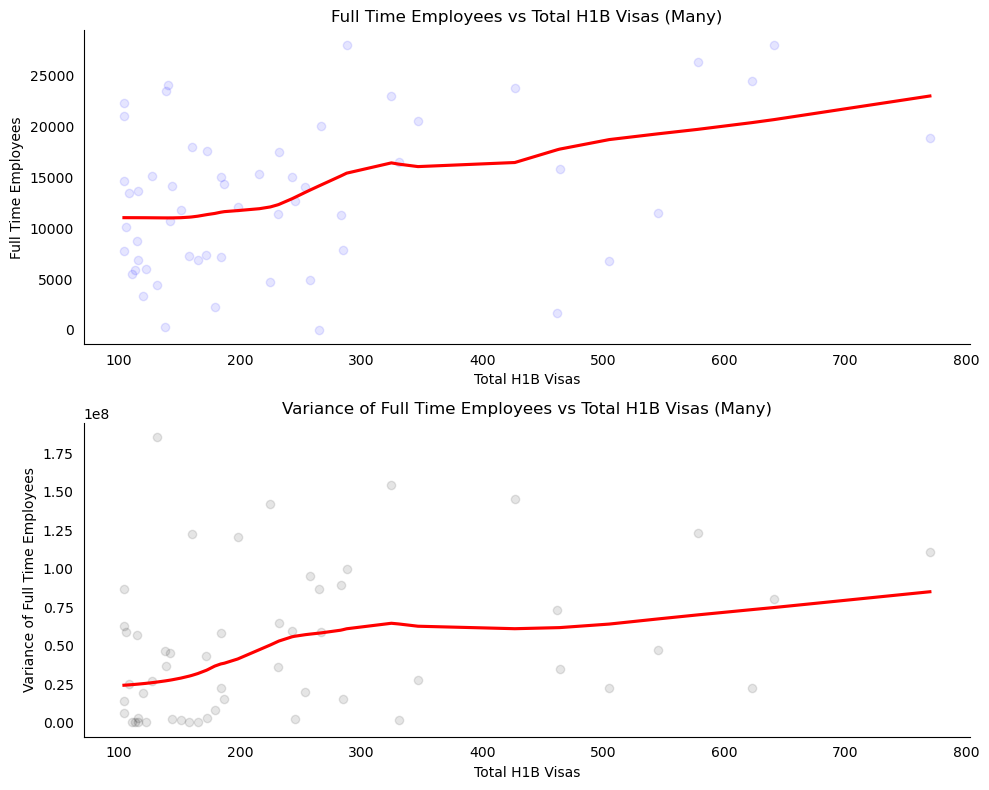

auditRisk


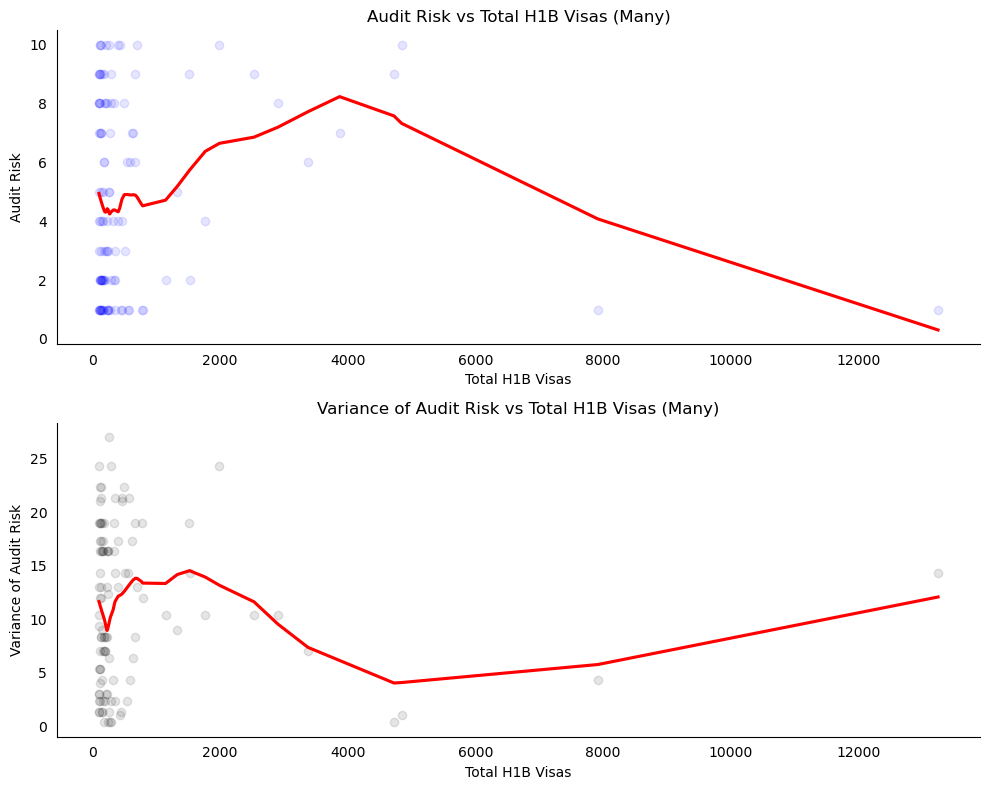

beta


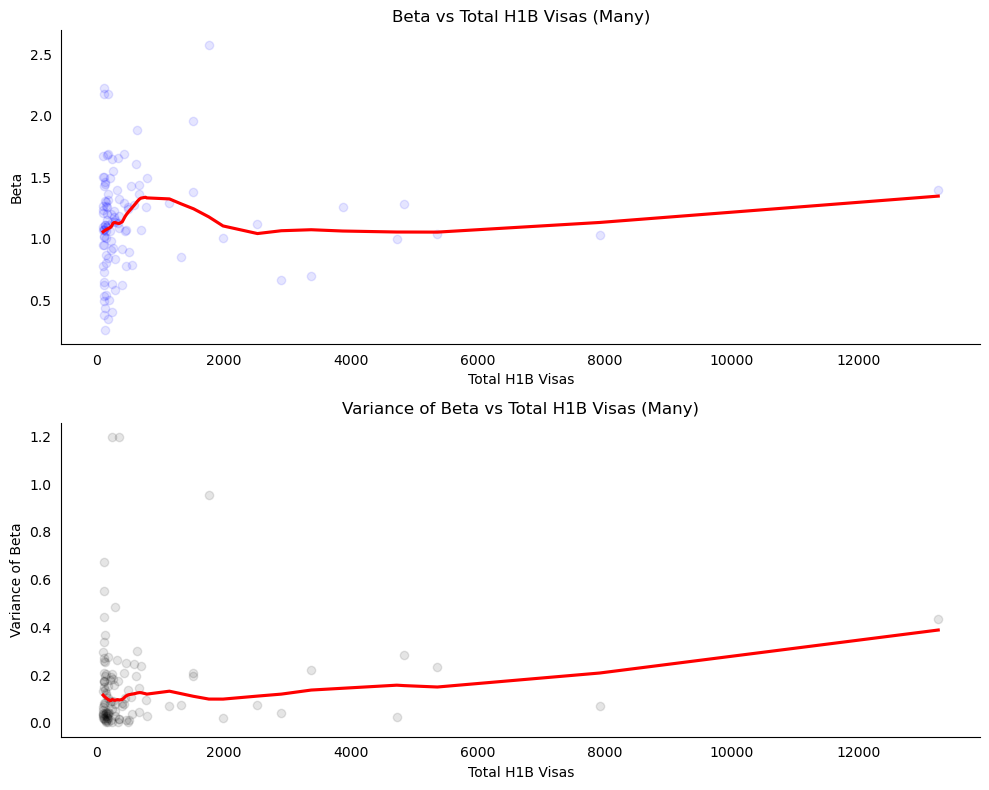

forwardPE


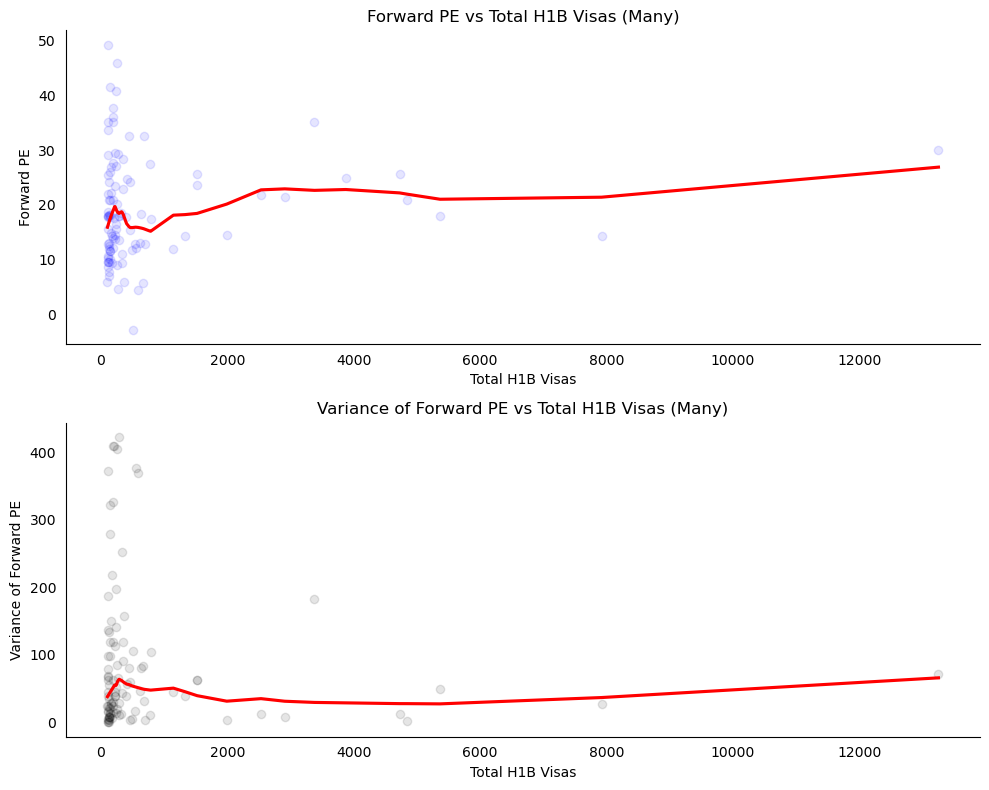

profitMargins


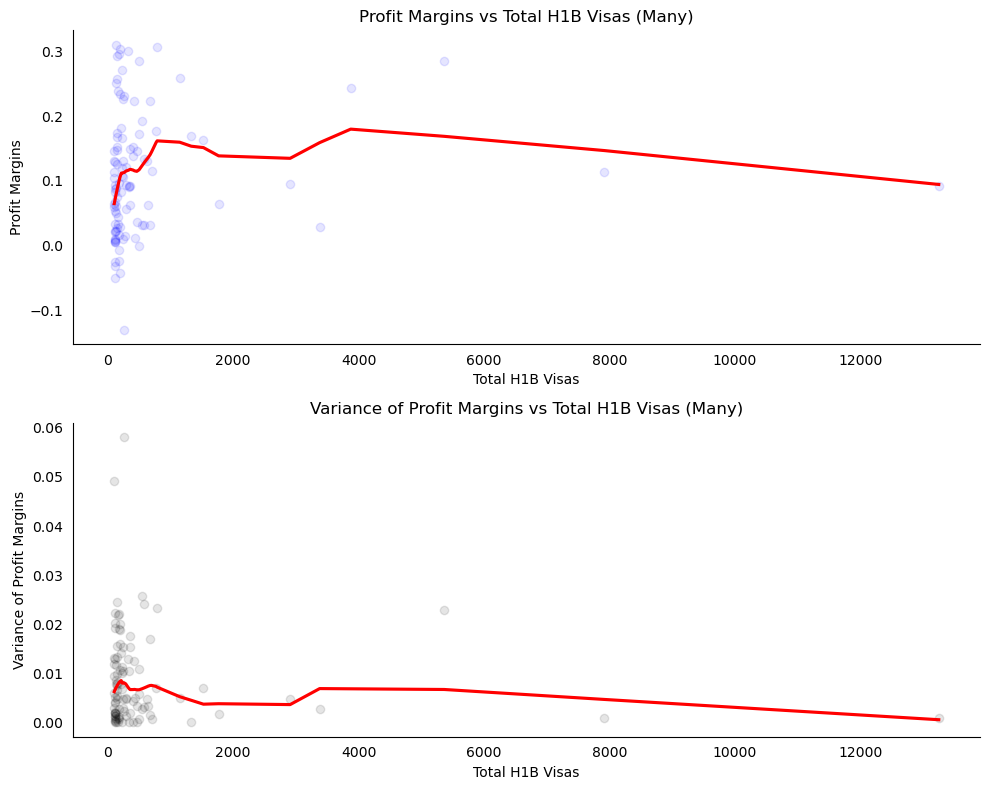

sharesPercentSharesOut


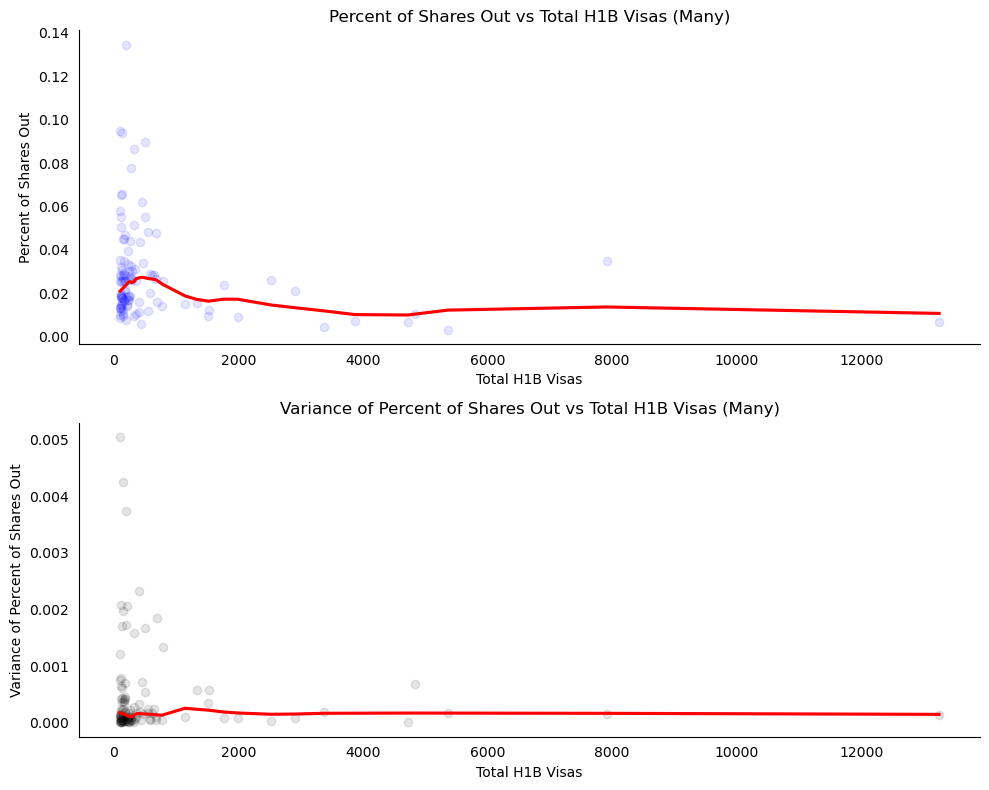

heldPercentInstitutions


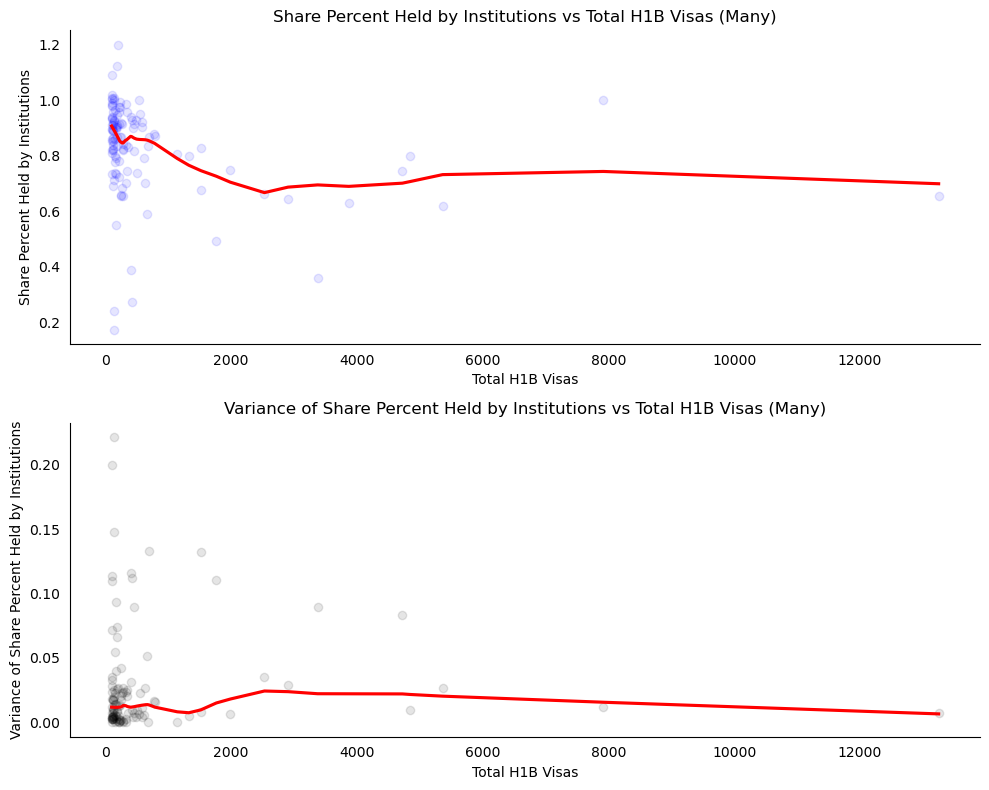

shortRatio


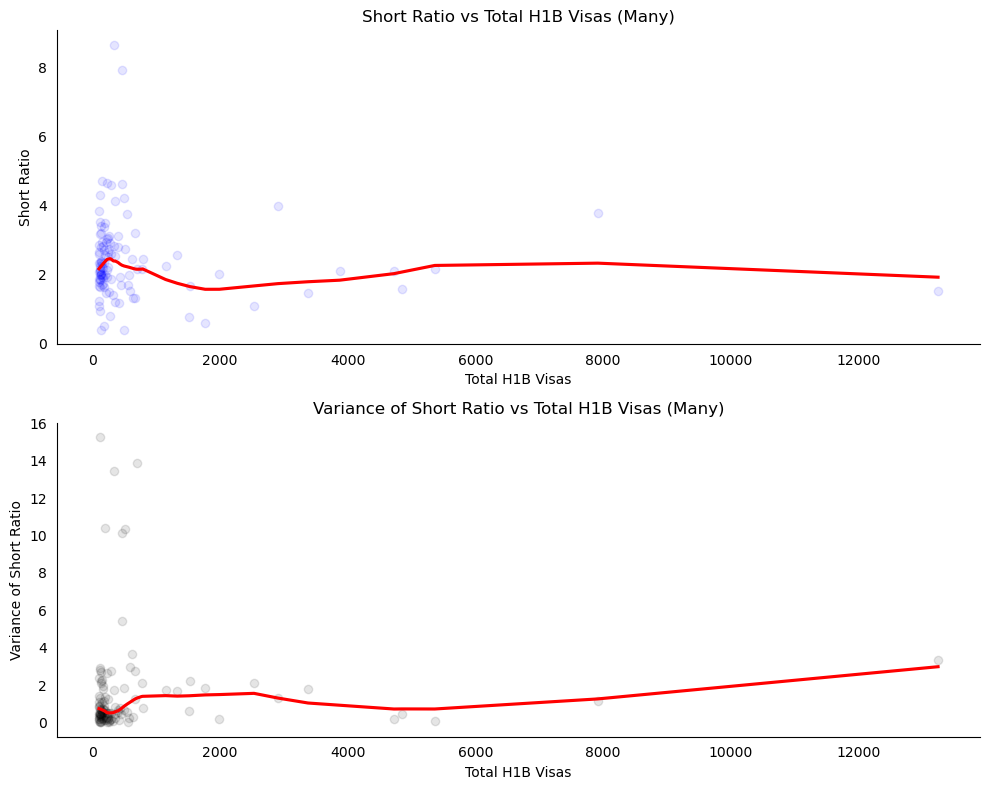

priceToBook


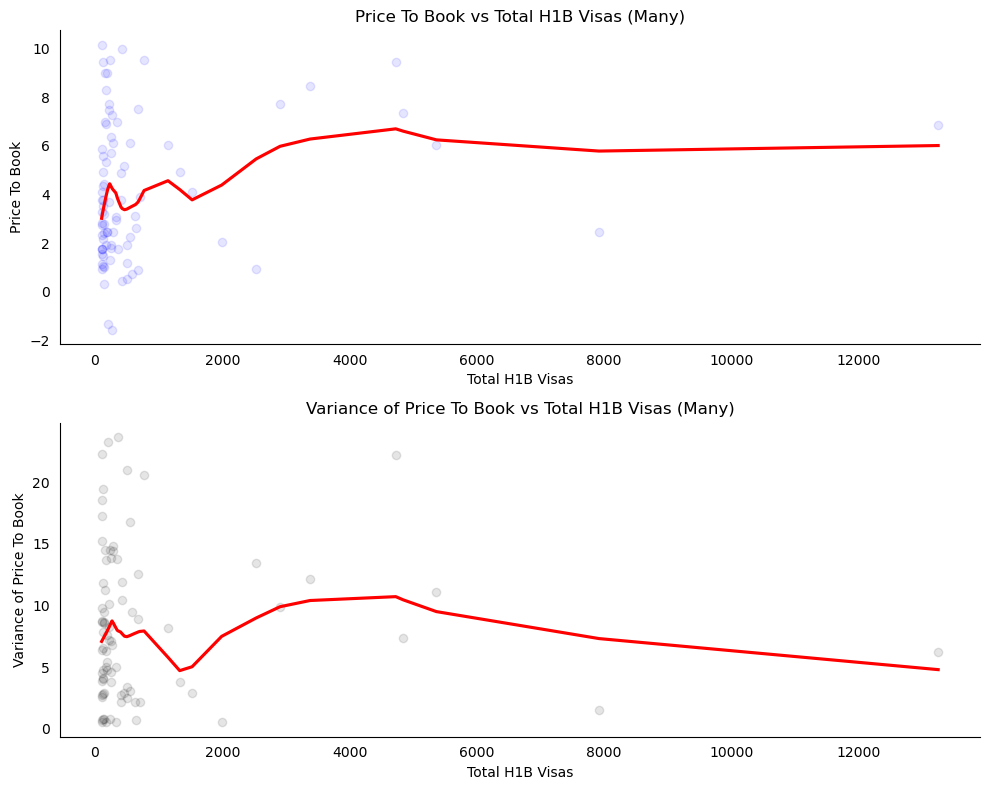

earningsQuarterlyGrowth


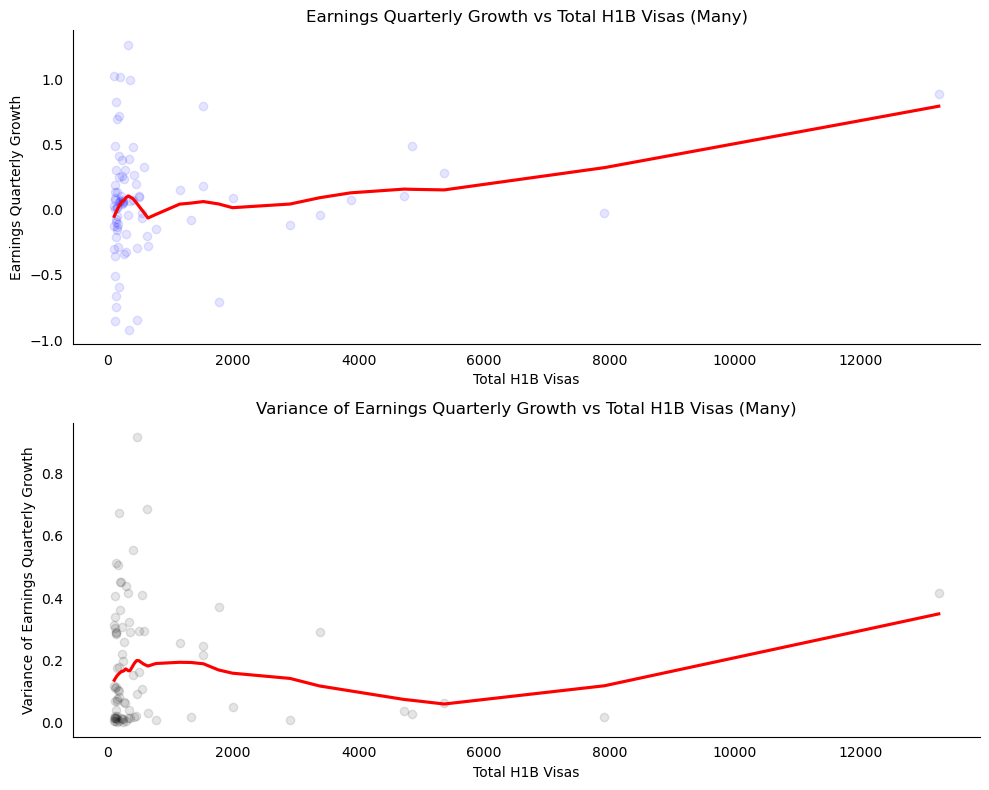

52WeekChange


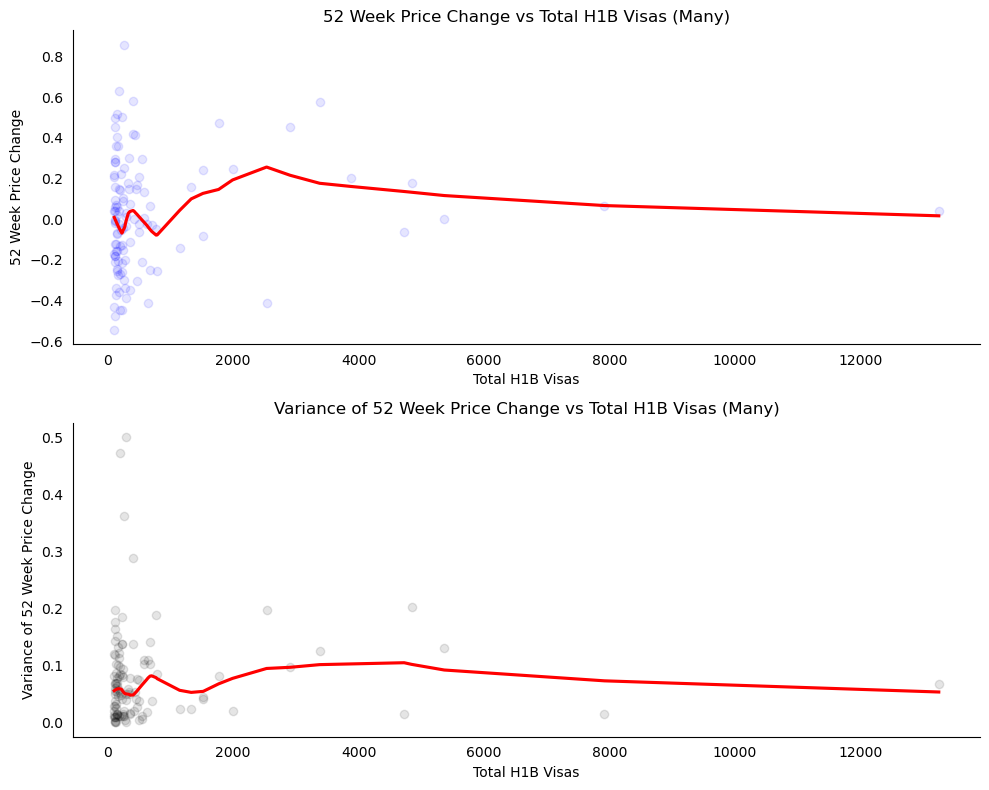

returnOnAssets


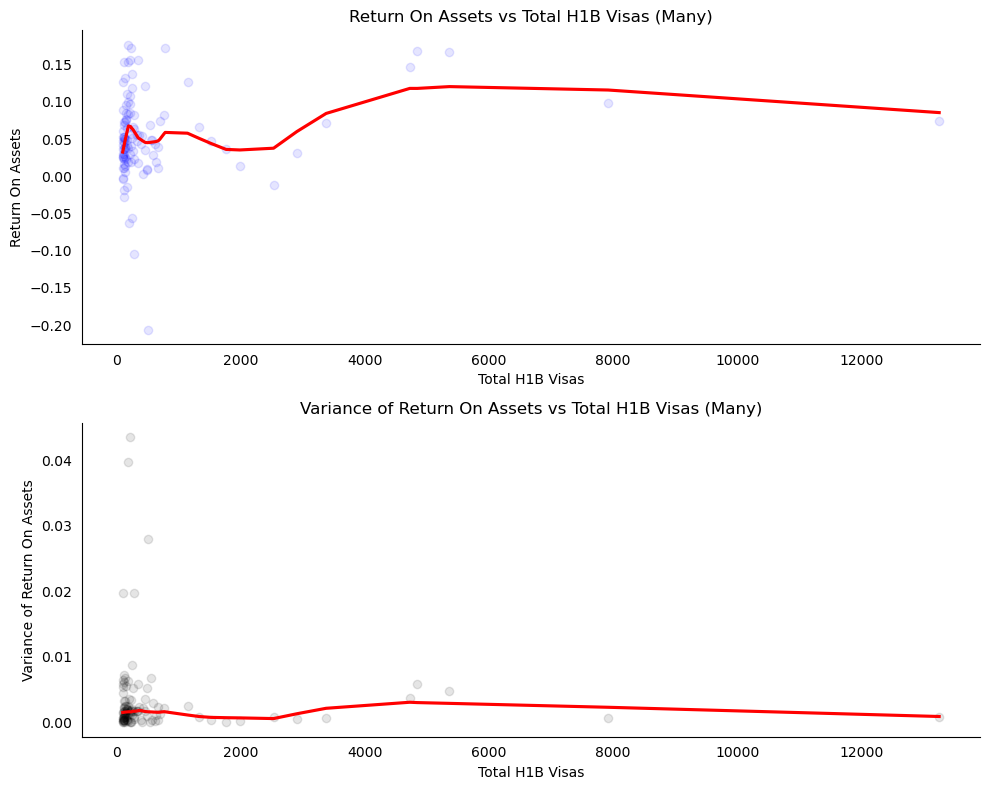

returnOnEquity


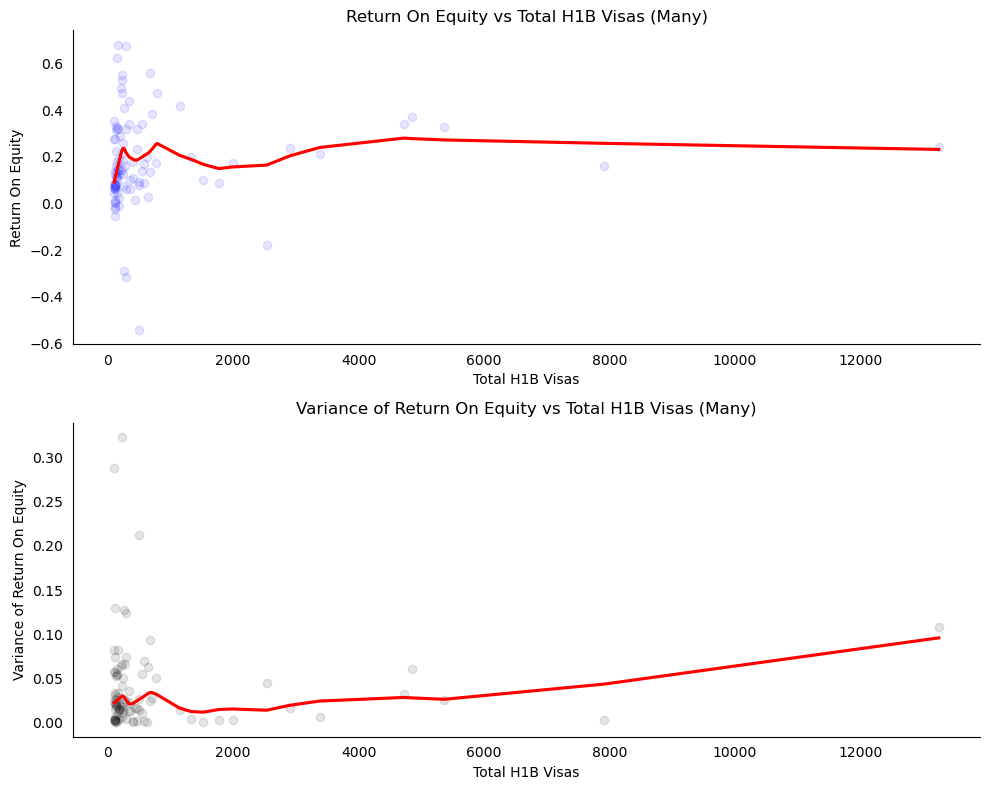

revenueGrowth


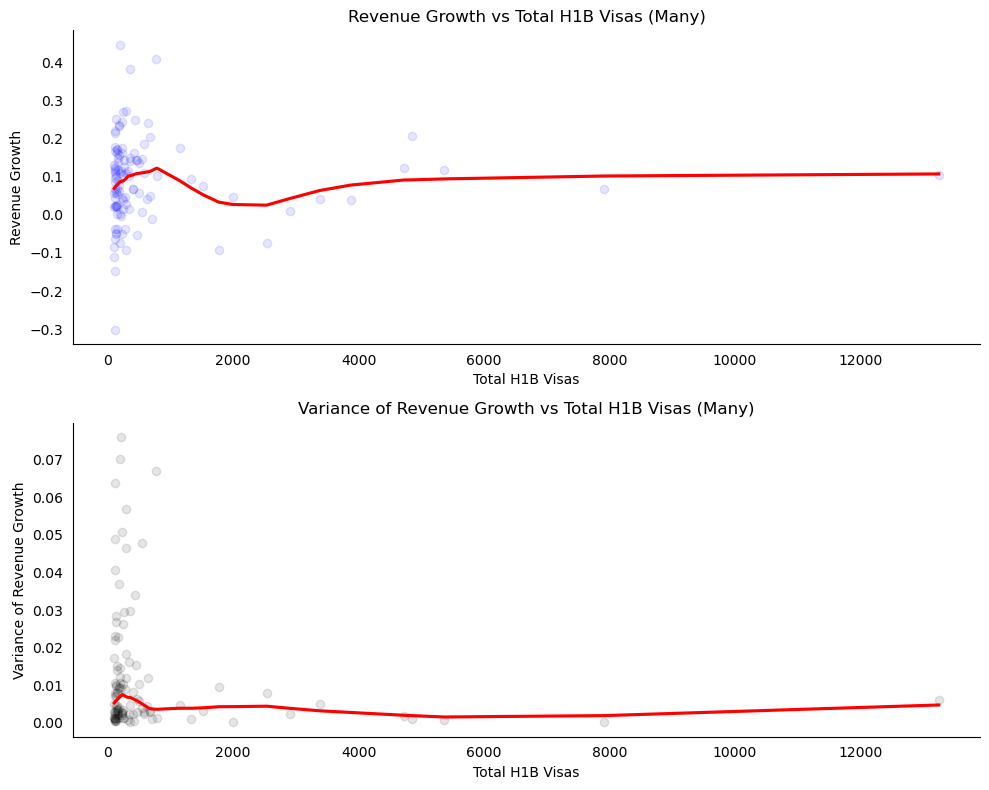

fiftyTwoWeekChangePercent


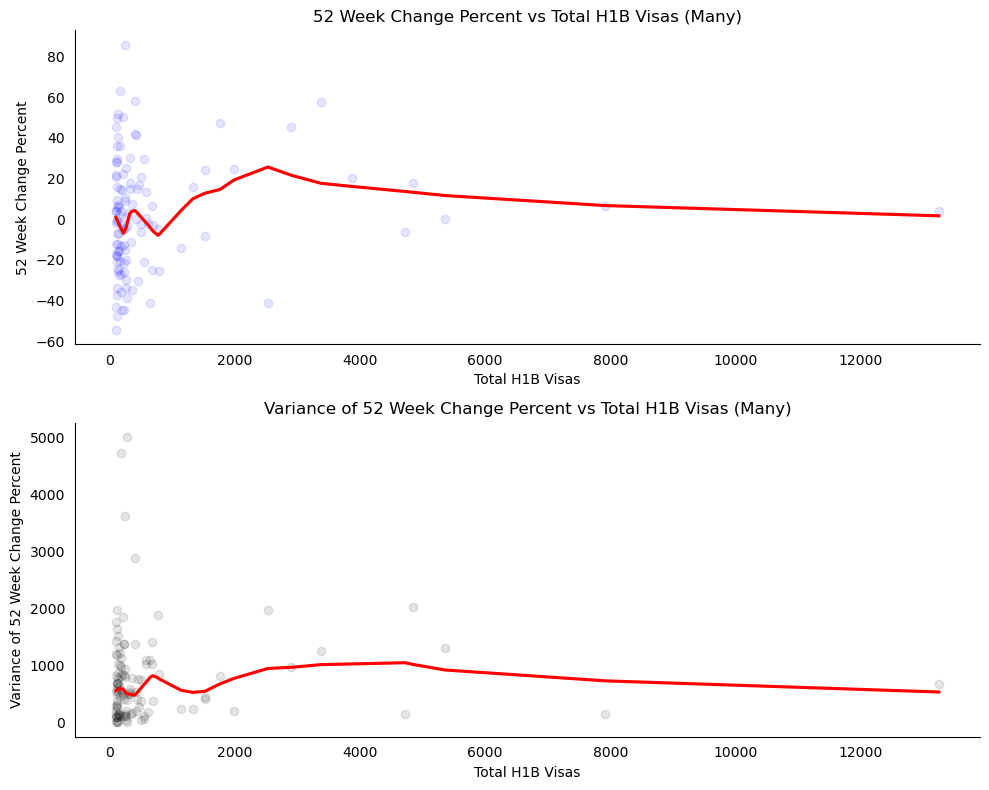

fiftyDayAverageChangePercent


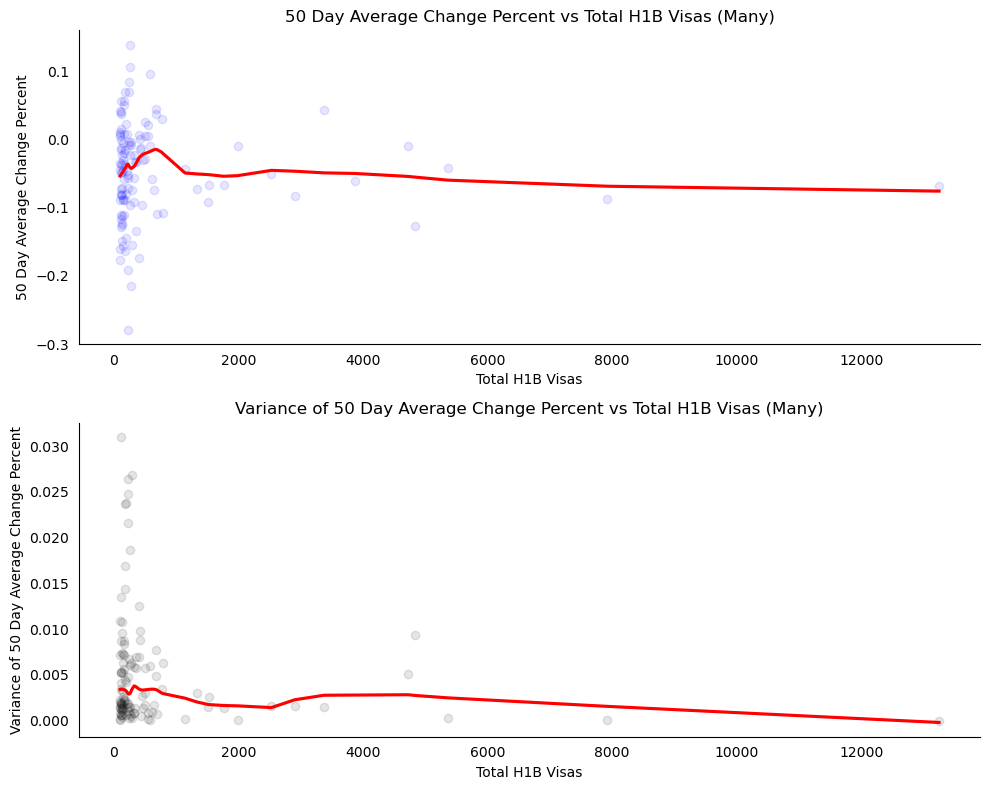

twoHundredDayAverageChangePercent


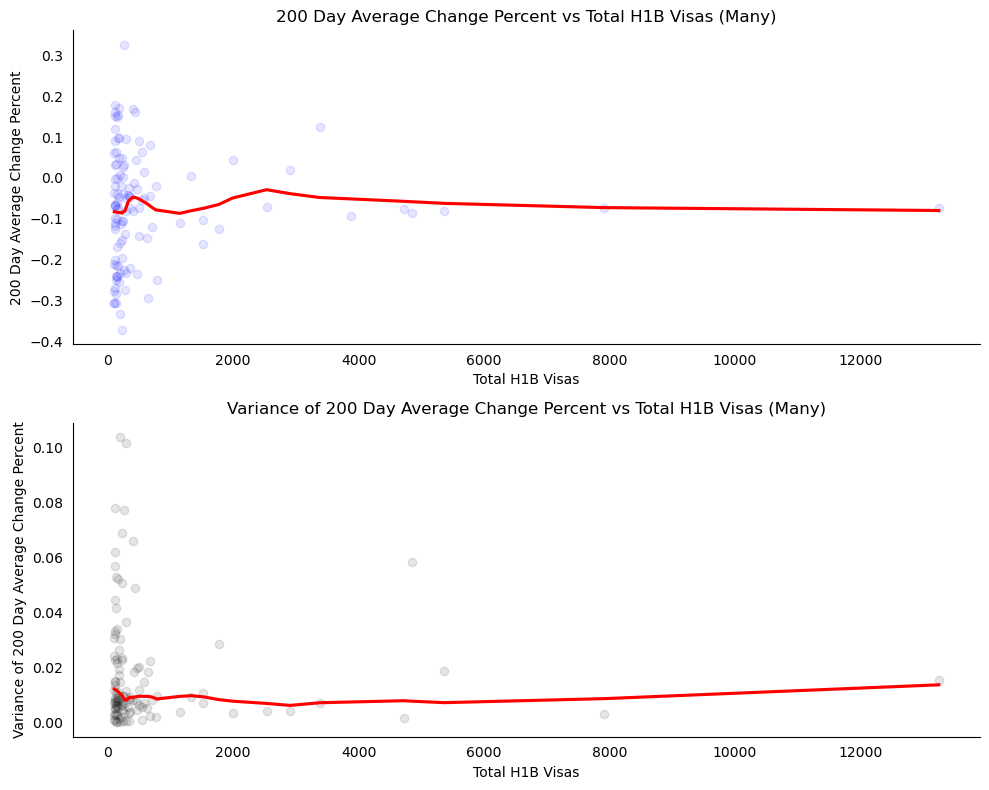

In [104]:
for n in range(17):
        col = graphs_with_patterns[n]
        if col != target_col:
            print(col)
            data = remove_outliers_iqr(visa_and_info_df, col)
            few_visas = data[data['tot_app'] <= 100]
            many_visas = data[data['tot_app'] > 100]

            fig, axs = plt.subplots(2, 1, figsize=(10, 8))

            sns.regplot(x=many_visas[target_col], y=many_visas[col], ax=axs[0], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
            axs[0].set_title(f'{pretty_titles[n]} vs Total H1B Visas (Many)')
            axs[0].set_xlabel('Total H1B Visas')
            axs[0].set_ylabel(pretty_titles[n])
            axs[0].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[0].tick_params(axis='y', which='both', left=False)

            sns.regplot(x=many_visas[target_col], y=many_visas[col].rolling(window=3).var(), ax=axs[1], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'black'}, line_kws={'color': 'red'})
            axs[1].set_title(f'Variance of {pretty_titles[n]} vs Total H1B Visas (Many)')
            axs[1].set_ylabel(f'Variance of {pretty_titles[n]}')
            axs[1].set_xlabel('Total H1B Visas')
            axs[1].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[1].tick_params(axis='y', which='both', left=False)

            plt.tick_params(axis='x', which='both', bottom=False, top=False) 
            plt.tick_params(axis='y', which='both', left=False)
            sns.despine()
            plt.tight_layout()
            plt.show()

In [33]:
with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
    
companies = [entry["ticker"] for entry in data.values()]
no_visas = []

for c in companies:
    if c not in visa_and_info_df['symbol'].values:
        no_visas.append(c)

In [34]:
import random
random.seed(10)
sampled_no_visas = random.sample(no_visas, 1574)

#no_visa_info = fetch_stock_info(sampled_no_visas)
#no_visa_info.to_csv("no_visa_info.csv")

In [35]:
no_visa_info_df = pd.read_csv('no_visa_info.csv').T
no_visa_info_df = no_visa_info_df.rename(columns=no_visa_info_df.iloc[0]).drop(no_visa_info_df.index[0]).reset_index()
no_visa_info_df['visa'] = 0
#no_visa_info_df.rename(columns={'index': 'Unnamed: 0'}, inplace=True)
no_visa_info_df.head()

index                        address1  \
0  JAGX                 200 Pine Street   
1   RKT            1050 Woodward Avenue   
2  SRTS     851 Broken Sound Parkway NW   
3  ANGH  Al-Khatem Tower, WeWork Hub 71   
4  EVGN         13 Gad Feinstein Street   

                                            address2           city state  \
0                                          Suite 400  San Francisco    CA   
1                                                NaN        Detroit    MI   
2                                          Suite 215     Boca Raton    FL   
3  16th Floor Abu Dhabi Global Market Square Al M...      Abu Dhabi   NaN   
4                                       Park Rehovot        Rehovot   NaN   

       zip               country           phone  \
0    94104         United States    415 371 8300   
1    48226         United States    313 373 7990   
2    33487         United States    561 922 5808   
3      NaN  United Arab Emirates             NaN   
4  7638517                Israel  972 8 931 1900   

                           website          industry  ... netAssets  \
0            https://jaguar.health     Biotechnology  ...       NaN   
1  https://www.rocketcompanies.com  Mortgage Finance  ...       NaN   
2     https://sensushealthcare.com   Medical Devices  ...       NaN   
3          https://www.anghami.com     Entertainment  ...       NaN   
4          https://www.evogene.com     Biotechnology  ...       NaN   

  netExpenseRatio postMarketTime postMarketChangePercent postMarketPrice  \
0             NaN            NaN                     NaN             NaN   
1             NaN            NaN                     NaN             NaN   
2             NaN            NaN                     NaN             NaN   
3             NaN            NaN                     NaN             NaN   
4             NaN            NaN                     NaN             NaN   

  postMarketChange prevExchange exchangeTransferDate newListingDate visa  
0              NaN          NaN                  NaN            NaN    0  
1              NaN          NaN                  NaN            NaN    0  
2              NaN          NaN                  NaN            NaN    0  
3              NaN          NaN                  NaN            NaN    0  
4              NaN          NaN                  NaN            NaN    0  

[5 rows x 205 columns]

In [36]:
company_info_df['visa'] = 1
company_info_df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
company_info_df.head()

index                      address1         city state         zip  \
0     A  5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
1    AA           201 Isabella Street   Pittsburgh    PA  15212-5858   
2   AAL               1 Skyview Drive   Fort Worth    TX       76155   
3  AAMI          200 Clarendon Street       Boston    MA       02116   
4  AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

         country           phone           fax                  website  \
0  United States    800 227 9770  866 497 1134  https://www.agilent.com   
1  United States    412 315 2900           NaN    https://www.alcoa.com   
2  United States    682 278 9000           NaN       https://www.aa.com   
3  United States    617-369-7300           NaN     https://www.bsig.com   
4  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                  industry  ... firstTradeDateMilliseconds  \
0   Diagnostics & Research  ...               9.429354e+11   
1                 Aluminum  ...              -2.523222e+11   
2                 Airlines  ...               1.127828e+12   
3         Asset Management  ...               1.412861e+12   
4  Communication Equipment  ...               1.380202e+12   

  regularMarketChange regularMarketDayRange               displayName  \
0            0.980003        103.16 - 106.0                   Agilent   
1            1.175001         25.28 - 26.24                     Alcoa   
2            0.169900           9.21 - 9.68         American Airlines   
3            0.340000       26.2151 - 26.89  Acadian Asset Management   
4            0.704400        11.535 - 12.59   Applied Optoelectronics   

   trailingPegRatio    address2                            prevName  \
0            1.7168         NaN                                 NaN   
1               NaN   Suite 500                                 NaN   
2            0.2903         NaN                                 NaN   
3               NaN  53rd Floor  BrightSphere Investment Group Inc.   
4               NaN         NaN                                 NaN   

   ipoExpectedDate  totalAssets visa  
0              NaN          NaN    1  
1              NaN          NaN    1  
2              NaN          NaN    1  
3              NaN          NaN    1  
4              NaN          NaN    1  

[5 rows x 150 columns]

In [37]:
dummy_visas = pd.concat([no_visa_info_df, company_info_df])
dummy_visas.head()
#dummy_visas.tail()

index                        address1  \
0  JAGX                 200 Pine Street   
1   RKT            1050 Woodward Avenue   
2  SRTS     851 Broken Sound Parkway NW   
3  ANGH  Al-Khatem Tower, WeWork Hub 71   
4  EVGN         13 Gad Feinstein Street   

                                            address2           city state  \
0                                          Suite 400  San Francisco    CA   
1                                                NaN        Detroit    MI   
2                                          Suite 215     Boca Raton    FL   
3  16th Floor Abu Dhabi Global Market Square Al M...      Abu Dhabi   NaN   
4                                       Park Rehovot        Rehovot   NaN   

       zip               country           phone  \
0    94104         United States    415 371 8300   
1    48226         United States    313 373 7990   
2    33487         United States    561 922 5808   
3      NaN  United Arab Emirates             NaN   
4  7638517                Israel  972 8 931 1900   

                           website          industry  ... netAssets  \
0            https://jaguar.health     Biotechnology  ...       NaN   
1  https://www.rocketcompanies.com  Mortgage Finance  ...       NaN   
2     https://sensushealthcare.com   Medical Devices  ...       NaN   
3          https://www.anghami.com     Entertainment  ...       NaN   
4          https://www.evogene.com     Biotechnology  ...       NaN   

  netExpenseRatio postMarketTime postMarketChangePercent postMarketPrice  \
0             NaN            NaN                     NaN             NaN   
1             NaN            NaN                     NaN             NaN   
2             NaN            NaN                     NaN             NaN   
3             NaN            NaN                     NaN             NaN   
4             NaN            NaN                     NaN             NaN   

  postMarketChange prevExchange exchangeTransferDate newListingDate visa  
0              NaN          NaN                  NaN            NaN    0  
1              NaN          NaN                  NaN            NaN    0  
2              NaN          NaN                  NaN            NaN    0  
3              NaN          NaN                  NaN            NaN    0  
4              NaN          NaN                  NaN            NaN    0  

[5 rows x 205 columns]

In [38]:
dummy_visas.set_index(dummy_visas.columns[0], inplace=True)

In [39]:
dummy_visas.head()

address1  \
index                                   
JAGX                  200 Pine Street   
RKT              1050 Woodward Avenue   
SRTS      851 Broken Sound Parkway NW   
ANGH   Al-Khatem Tower, WeWork Hub 71   
EVGN          13 Gad Feinstein Street   

                                                address2           city state  \
index                                                                           
JAGX                                           Suite 400  San Francisco    CA   
RKT                                                  NaN        Detroit    MI   
SRTS                                           Suite 215     Boca Raton    FL   
ANGH   16th Floor Abu Dhabi Global Market Square Al M...      Abu Dhabi   NaN   
EVGN                                        Park Rehovot        Rehovot   NaN   

           zip               country           phone  \
index                                                  
JAGX     94104         United States    415 371 8300   
RKT      48226         United States    313 373 7990   
SRTS     33487         United States    561 922 5808   
ANGH       NaN  United Arab Emirates             NaN   
EVGN   7638517                Israel  972 8 931 1900   

                               website          industry       industryKey  \
index                                                                        
JAGX             https://jaguar.health     Biotechnology     biotechnology   
RKT    https://www.rocketcompanies.com  Mortgage Finance  mortgage-finance   
SRTS      https://sensushealthcare.com   Medical Devices   medical-devices   
ANGH           https://www.anghami.com     Entertainment     entertainment   
EVGN           https://www.evogene.com     Biotechnology     biotechnology   

       ... netAssets netExpenseRatio postMarketTime postMarketChangePercent  \
index  ...                                                                    
JAGX   ...       NaN             NaN            NaN                     NaN   
RKT    ...       NaN             NaN            NaN                     NaN   
SRTS   ...       NaN             NaN            NaN                     NaN   
ANGH   ...       NaN             NaN            NaN                     NaN   
EVGN   ...       NaN             NaN            NaN                     NaN   

      postMarketPrice postMarketChange prevExchange exchangeTransferDate  \
index                                                                      
JAGX              NaN              NaN          NaN                  NaN   
RKT               NaN              NaN          NaN                  NaN   
SRTS              NaN              NaN          NaN                  NaN   
ANGH              NaN              NaN          NaN                  NaN   
EVGN              NaN              NaN          NaN                  NaN   

      newListingDate visa  
index                      
JAGX             NaN    0  
RKT              NaN    0  
SRTS             NaN    0  
ANGH             NaN    0  
EVGN             NaN    0  

[5 rows x 204 columns]

In [40]:
import numpy as np
dv_numerical = dummy_visas[dummy_visas['country'] == 'United States']#.select_dtypes(include=[np.number])

In [41]:
keep_cols = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'visa']
dv_numericals = dv_numerical[keep_cols]


In [42]:
dv_numericals = dv_numericals.loc[:, ~dv_numericals.columns.duplicated()].astype(float)
dv_numericals.head()

fullTimeEmployees  auditRisk   beta  forwardPE  profitMargins  \
index                                                                  
JAGX                49.0        NaN  1.115  -4.055556        0.00000   
RKT              14200.0        3.0  2.356  19.378788        0.00542   
SRTS                54.0        NaN  1.115   8.146552        0.15899   
FCX              28500.0        6.0  1.708  17.268517        0.07111   
AMAL               429.0        2.0  0.743   8.011494        0.34981   

       sharesPercentSharesOut  heldPercentInstitutions  shortRatio  \
index                                                                
JAGX                   0.0778                  0.01665        1.44   
RKT                    0.1744                  0.74550        2.60   
SRTS                   0.0508                  0.30152        6.71   
FCX                    0.0194                  0.85644        1.49   
AMAL                   0.0511                  0.64978        5.69   

       priceToBook  earningsQuarterlyGrowth  52WeekChange  returnOnAssets  \
index                                                                       
JAGX      0.767808                      NaN     -0.970148        -0.36990   
RKT       2.658491                      NaN      0.065587         0.03250   
SRTS      3.017241                    4.224      0.372434         0.08727   
FCX       2.952351                   -0.256     -0.254851         0.07496   
AMAL      1.208391                    0.079      0.126423         0.01312   

       returnOnEquity  revenueGrowth  fiftyTwoWeekChangePercent  \
index                                                             
JAGX         -5.65739          0.526                 -97.014820   
RKT           0.07332          1.505                   6.558704   
SRTS          0.12701          1.557                  37.243400   
FCX           0.14062         -0.094                 -25.485146   
AMAL          0.16463          0.017                  12.642277   

       fiftyDayAverageChangePercent  twoHundredDayAverageChangePercent  visa  
index                                                                         
JAGX                      -0.008228                          -0.603698   0.0  
RKT                       -0.048632                          -0.147626   0.0  
SRTS                      -0.017467                          -0.250006   0.0  
FCX                        0.014867                          -0.107970   0.0  
AMAL                      -0.062845                          -0.132484   0.0

In [43]:
group_means = dv_numericals.groupby('visa').mean()

In [44]:
group_means.index = ['No H1B Employees', 'H1B Employees']
colors = ['blue', 'orange'] 
#for col in group_means.columns:
#    group_means[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Mean Value')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()


In [45]:
group_medians = dv_numericals.groupby('visa').median()

In [46]:
group_medians.index = ['No H1B Employees', 'H1B Employees']
#for col in group_medians.columns:
#    group_medians[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Median Value')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()

In [47]:
group_stds = dv_numericals.groupby('visa').std()
group_stds.index = ['No H1B Employees', 'H1B Employees']
#for col in group_medians.columns:
#    group_medians[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Standard Deviation')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()

In [48]:
import scipy.stats as stats

def check_significance(sample1, sample2, alpha=0.1):
    t_stat, p_value = stats.ttest_ind(sample1, sample2, equal_var=False) 
    if p_value < alpha:
        return f"Statistically significant (p = {p_value:.4f})", p_value
    else:
        return f"Not statistically significant (p = {p_value:.4f})", p_value



In [49]:
for x in dv_numericals.columns:
    if x != 'visa':
        result, p_value = check_significance(dv_numericals[dv_numericals['visa']==0][x], dv_numericals[dv_numericals['visa']==1][x])
        print(x)
        print(result)
        print()


fullTimeEmployees
Not statistically significant (p = nan)

auditRisk
Not statistically significant (p = nan)

beta
Not statistically significant (p = nan)

forwardPE
Not statistically significant (p = nan)

profitMargins
Statistically significant (p = 0.0029)

sharesPercentSharesOut
Not statistically significant (p = nan)

heldPercentInstitutions
Not statistically significant (p = nan)

shortRatio
Not statistically significant (p = nan)

priceToBook
Not statistically significant (p = nan)

earningsQuarterlyGrowth
Not statistically significant (p = nan)

52WeekChange
Not statistically significant (p = nan)

returnOnAssets
Not statistically significant (p = nan)

returnOnEquity
Not statistically significant (p = nan)

revenueGrowth
Not statistically significant (p = nan)

fiftyTwoWeekChangePercent
Not statistically significant (p = nan)

fiftyDayAverageChangePercent
Not statistically significant (p = nan)

twoHundredDayAverageChangePercent
Not statistically significant (p = nan)



In [50]:
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf

In [51]:
for x in dv_numericals.columns:
    if x != 'visa':
        try:
            print(x)
            print(smf.ols('visa ~ '+x, data=dv_numericals).fit().summary())
            print()
        except:
            print("Error with "+x)

fullTimeEmployees
                            OLS Regression Results                            
Dep. Variable:                   visa   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.247
Date:                Wed, 30 Apr 2025   Prob (F-statistic):             0.0125
Time:                        14:25:35   Log-Likelihood:                -1711.3
No. Observations:                2954   AIC:                             3427.
Df Residuals:                    2952   BIC:                             3439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           

In [52]:
for x in dv_numericals.columns:
    for y in dv_numericals.columns:
        if x != 'visa' and x!=y:
            try:
                print(x +" and "+y)
                print(smf.ols('visa ~ '+x+' + '+y, data=dv_numericals).fit().summary())
                print()
            except:
                print("Error with ")

fullTimeEmployees and auditRisk
                            OLS Regression Results                            
Dep. Variable:                   visa   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.513
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           0.000208
Time:                        14:25:36   Log-Likelihood:                -856.67
No. Observations:                1993   AIC:                             1719.
Df Residuals:                    1990   BIC:                             1736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Interc

In [53]:
print(smf.ols('visa ~ '+" + ".join(col for col in dv_numericals.columns if col != 'visa' and col != '52WeekChange'), data=dv_numericals).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   visa   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.297
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.23e-05
Time:                        14:25:40   Log-Likelihood:                -360.89
No. Observations:                 954   AIC:                             755.8
Df Residuals:                     937   BIC:                             838.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [54]:
#fetch_stock_data(dv_numericals.index)

In [55]:
price_df = pd.read_csv('sp500_data.csv')

C:\Users\owenh\AppData\Local\Temp\ipykernel_40104\4101784014.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [56]:
test_df = price_df.T
test_df.head()

0       1     2           3           4           5     \
Unnamed: 0  Price  Ticker  Date  2020-01-02  2020-01-03  2020-01-06   
JAGX        Close    JAGX   NaN    265612.5    251775.0    258862.5   
JAGX.1       High    JAGX   NaN    324000.0    256500.0    259875.0   
JAGX.2        Low    JAGX   NaN    249750.0    226125.0    242325.0   
JAGX.3       Open    JAGX   NaN    294300.0    236587.5    256500.0   

                  6           7           8           9     ...        1300  \
Unnamed: 0  2020-01-07  2020-01-08  2020-01-09  2020-01-10  ...  2025-03-03   
JAGX          267300.0    273375.0    267637.5    255825.0  ...        14.4   
JAGX.1        312187.5    293625.0    279787.5    273375.0  ...       15.75   
JAGX.2        259875.0    259875.0    264937.5    253125.0  ...       13.75   
JAGX.3        266625.0    286875.0    270000.0    271012.5  ...        15.5   

                  1301        1302        1303        1304        1305  \
Unnamed: 0  2025-03-04  2025-03-05  2025-03-06  2025-03-07  2025-03-10   
JAGX             14.25      14.775      14.475      14.425      13.675   
JAGX.1            14.4        15.0      15.125       14.75       15.05   
JAGX.2           13.75      14.275        14.0       13.95        13.2   
JAGX.3           14.25      14.275        15.0      14.125        14.5   

                  1306        1307        1308        1309  
Unnamed: 0  2025-03-11  2025-03-12  2025-03-13  2025-03-14  
JAGX            11.925        12.0      11.225      11.125  
JAGX.1           13.75        13.0      12.425      11.375  
JAGX.2           11.75        11.5        11.0      10.525  
JAGX.3           13.75        13.0      11.775       11.25  

[5 rows x 1310 columns]

In [57]:
filtered_df = test_df[~test_df.index.str.contains(r'\d')].T
filtered_df.head()

JAGX    RKT                SRTS                 FCX  \
0     Close  Close               Close               Close   
1      JAGX    RKT                SRTS                 FCX   
2       NaN    NaN                 NaN                 NaN   
3  265612.5    NaN   3.690000057220459  12.393362045288086   
4  251775.0    NaN  3.6700000762939453  12.017806053161621   

                 AMAL   NEUE      PLMKW                CLFD      RANGR  \
0               Close  Close  Adj Close               Close  Adj Close   
1                AMAL   NEUE      PLMKW                CLFD      RANGR   
2                 NaN    NaN        NaN                 NaN        NaN   
3  17.358104705810547    NaN        NaN  13.930000305175781        NaN   
4  17.294981002807617    NaN        NaN  13.729999542236328        NaN   

                LGIH  ...                 UDR                VANI   VERA  \
0              Close  ...               Close               Close  Close   
1               LGIH  ...                 UDR                VANI   VERA   
2                NaN  ...                 NaN                 NaN    NaN   
3  70.62000274658203  ...  37.553367614746094  17.687999725341797    NaN   
4  71.05999755859375  ...  37.854644775390625  16.200000762939453    NaN   

                VSEC      WGSWW                WKC     WS                  WT  \
0              Close  Adj Close              Close  Close               Close   
1               VSEC      WGSWW                WKC     WS                  WT   
2                NaN        NaN                NaN    NaN                 NaN   
3  35.92429733276367        NaN  38.83309555053711    NaN  4.2175726890563965   
4  36.09650802612305        NaN  38.40150833129883    NaN   4.109889507293701   

                WTRG               ZVRA  
0              Close              Close  
1               WTRG               ZVRA  
2                NaN                NaN  
3  39.91403579711914  6.480000019073486  
4  40.20111083984375  6.559999942779541  

[5 rows x 3084 columns]

In [58]:
filtered_df.columns = filtered_df.iloc[1]
filtered_df.head()

1      JAGX    RKT                SRTS                 FCX  \
0     Close  Close               Close               Close   
1      JAGX    RKT                SRTS                 FCX   
2       NaN    NaN                 NaN                 NaN   
3  265612.5    NaN   3.690000057220459  12.393362045288086   
4  251775.0    NaN  3.6700000762939453  12.017806053161621   

1                AMAL   NEUE      PLMKW                CLFD      RANGR  \
0               Close  Close  Adj Close               Close  Adj Close   
1                AMAL   NEUE      PLMKW                CLFD      RANGR   
2                 NaN    NaN        NaN                 NaN        NaN   
3  17.358104705810547    NaN        NaN  13.930000305175781        NaN   
4  17.294981002807617    NaN        NaN  13.729999542236328        NaN   

1               LGIH  ...                 UDR                VANI   VERA  \
0              Close  ...               Close               Close  Close   
1               LGIH  ...                 UDR                VANI   VERA   
2                NaN  ...                 NaN                 NaN    NaN   
3  70.62000274658203  ...  37.553367614746094  17.687999725341797    NaN   
4  71.05999755859375  ...  37.854644775390625  16.200000762939453    NaN   

1               VSEC      WGSWW                WKC     WS                  WT  \
0              Close  Adj Close              Close  Close               Close   
1               VSEC      WGSWW                WKC     WS                  WT   
2                NaN        NaN                NaN    NaN                 NaN   
3  35.92429733276367        NaN  38.83309555053711    NaN  4.2175726890563965   
4  36.09650802612305        NaN  38.40150833129883    NaN   4.109889507293701   

1               WTRG               ZVRA  
0              Close              Close  
1               WTRG               ZVRA  
2                NaN                NaN  
3  39.91403579711914  6.480000019073486  
4  40.20111083984375  6.559999942779541  

[5 rows x 3084 columns]

In [59]:
filtered_df.iloc[3:].astype(float).to_csv('clean_prices.csv')

In [60]:
filtered_df = pd.read_csv('clean_prices.csv').drop(columns='Unnamed: 0')
filtered_df.head()

JAGX  RKT  SRTS        FCX       AMAL  NEUE  PLMKW   CLFD  RANGR  \
0  265612.5  NaN  3.69  12.393362  17.358105   NaN    NaN  13.93    NaN   
1  251775.0  NaN  3.67  12.017806  17.294981   NaN    NaN  13.73    NaN   
2  258862.5  NaN  3.68  12.064751  17.033484   NaN    NaN  13.84    NaN   
3  267300.0  NaN  3.60  12.252529  16.808052   NaN    NaN  13.87    NaN   
4  273375.0  NaN  3.57  12.374583  17.132671   NaN    NaN  13.83    NaN   

        LGIH  ...        UDR       VANI  VERA       VSEC  WGSWW        WKC  \
0  70.620003  ...  37.553368  17.688000   NaN  35.924297    NaN  38.833096   
1  71.059998  ...  37.854645  16.200001   NaN  36.096508    NaN  38.401508   
2  72.279999  ...  37.773212  15.630000   NaN  36.249573    NaN  37.871040   
3  74.769997  ...  37.309090  14.190000   NaN  35.579887    NaN  37.520390   
4  75.790001  ...  37.357948  14.520000   NaN  35.225903    NaN  37.421478   

   WS        WT       WTRG   ZVRA  
0 NaN  4.217573  39.914036  6.480  
1 NaN  4.109890  40.201111  6.560  
2 NaN  4.091943  40.061928  6.928  
3 NaN  3.975286  40.296825  8.640  
4 NaN  3.939392  40.462109  8.192  

[5 rows x 3084 columns]

In [61]:
filtered_df = filtered_df.loc[:, ((filtered_df < 10000) & (filtered_df >= 1)).all()]

In [62]:
no_visa_tickers = dv_numericals[dv_numericals['visa'] == 0].index
visa_tickers = dv_numericals[dv_numericals['visa'] == 1].index
few_visas = visa_and_info_df[visa_and_info_df['tot_app'] < 100]['Unnamed: 0']
many_visas = visa_and_info_df[visa_and_info_df['tot_app'] >= 100]['Unnamed: 0']


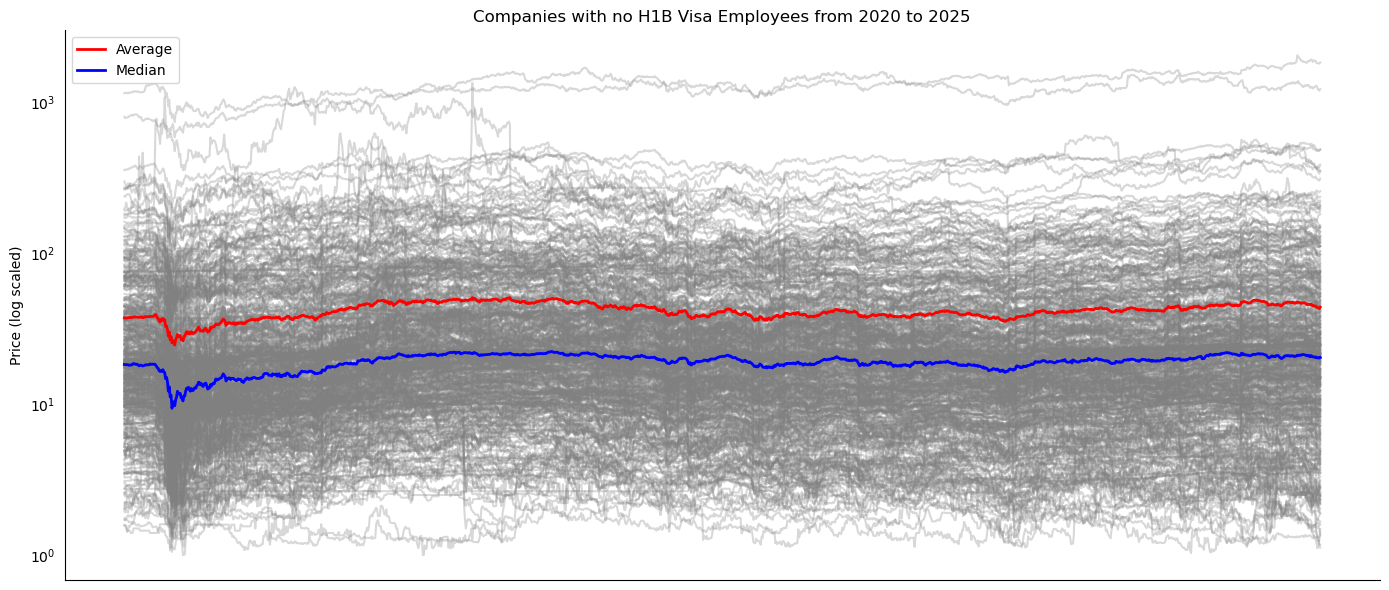

In [71]:
plt.figure(figsize=(14, 6))
avg_ticks = []
for ticker in no_visa_tickers:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        plt.plot(filtered_df[ticker], color = 'gray', alpha = .3)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
plt.plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
plt.plot(med_line, color='blue', label='Median', linewidth=2)

plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.xticks([])

plt.yscale('log')
plt.title("Companies with no H1B Visa Employees from 2020 to 2025")
plt.legend()
plt.ylabel("Price (log scaled)")
plt.tight_layout()
sns.despine()
plt.show()

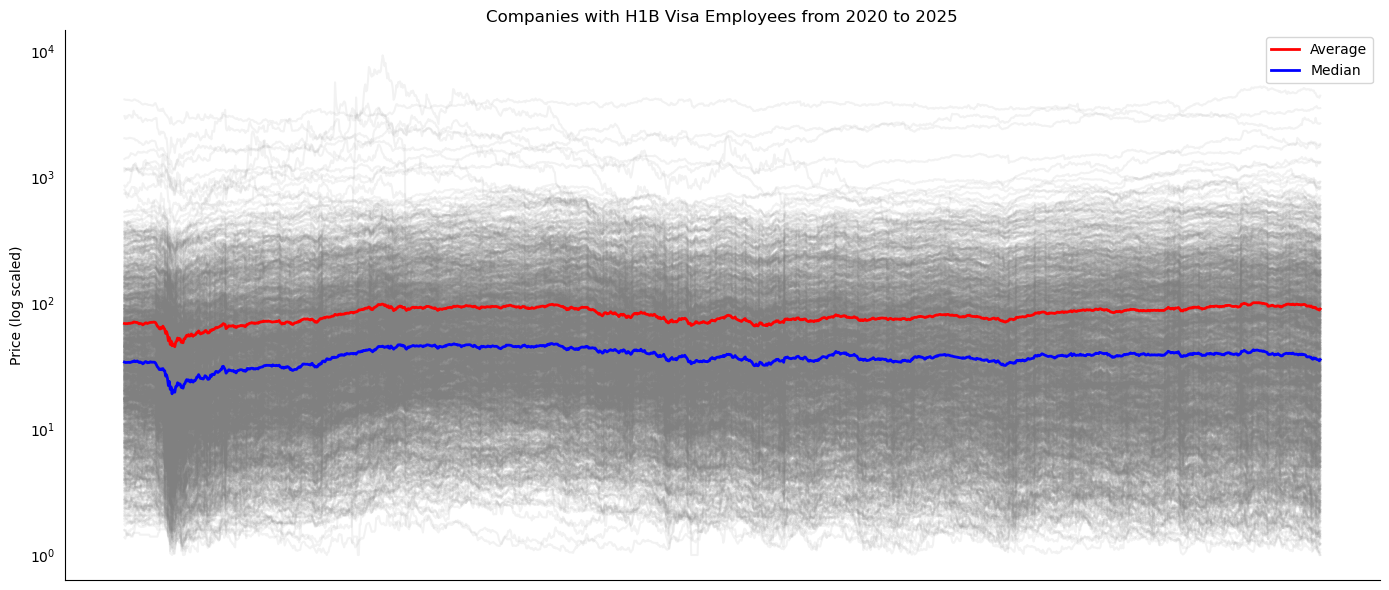

In [72]:
plt.figure(figsize=(14, 6))
avg_ticks= []
for ticker in visa_tickers:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        plt.plot(filtered_df[ticker], color = 'gray', alpha = .1)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
plt.plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
plt.plot(med_line, color='blue', label='Median', linewidth=2)

plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.xticks([])

plt.yscale('log')
plt.title("Companies with H1B Visa Employees from 2020 to 2025")
plt.legend()
plt.ylabel("Price (log scaled)")
plt.tight_layout()
sns.despine()
plt.show()

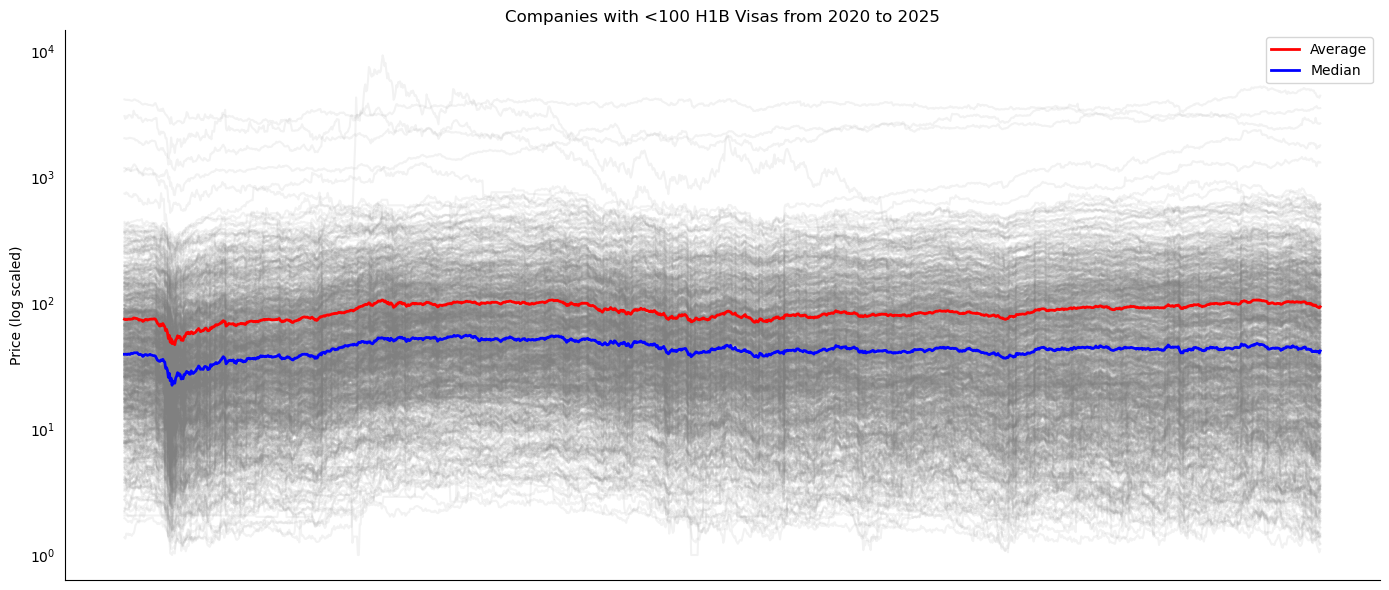

In [75]:
plt.figure(figsize=(14, 6))
avg_ticks = []
for ticker in few_visas:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        plt.plot(filtered_df[ticker], color = 'gray', alpha = .1)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
plt.plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
plt.plot(med_line, color='blue', label='Median', linewidth=2)

plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.xticks([])

plt.yscale('log')
plt.title("Companies with <100 H1B Visas from 2020 to 2025")
plt.ylabel("Price (log scaled)")
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()

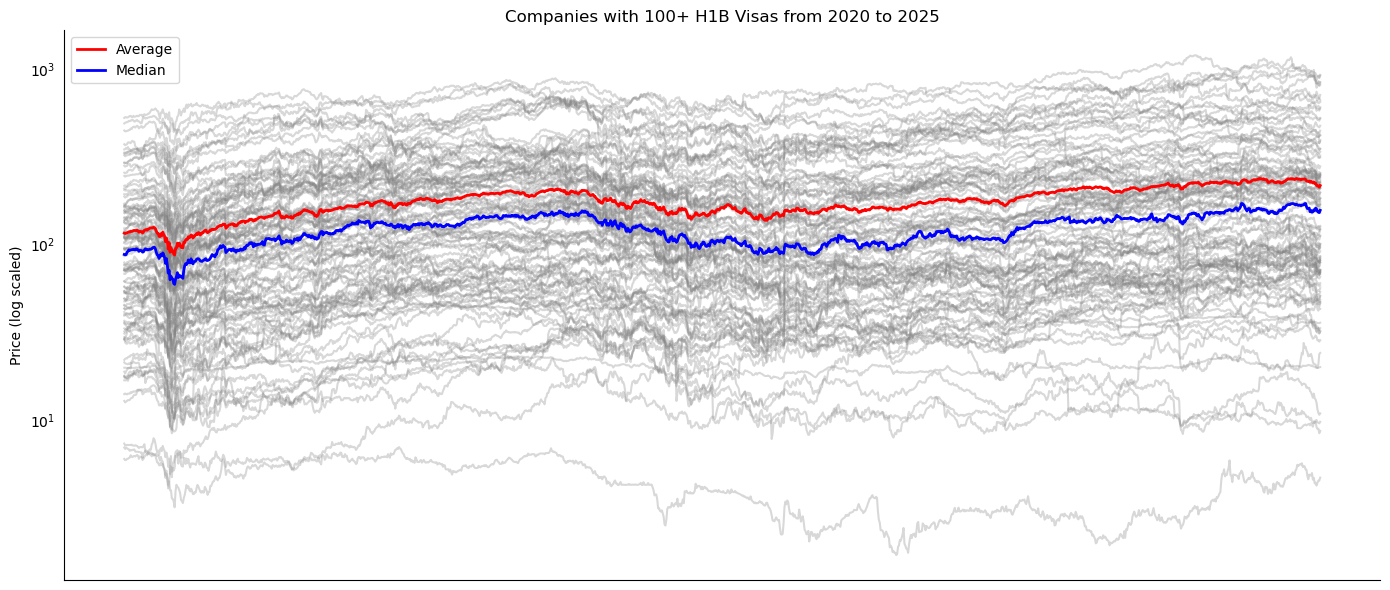

In [74]:
plt.figure(figsize=(14, 6))
avg_ticks = []
for ticker in many_visas:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        plt.plot(filtered_df[ticker], color = 'gray', alpha = .3)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
plt.plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
plt.plot(med_line, color='blue', label='Median', linewidth=2)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False)
plt.xticks([])
plt.yscale('log')
plt.title("Companies with 100+ H1B Visas from 2020 to 2025")
plt.ylabel("Price (log scaled)")
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()